# Setup

## Package Installation

In [1]:
#%pip install torchvision
#!pip uninstall -y torch torchvision torchaudio
#%pip install torch==2.6.0+cu124 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [2]:
import os
import random
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR100
from torchvision.models import resnet50, resnet18
from PIL import Image
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
import gc

print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using the device {}.'.format(device))
if torch.cuda.is_available():
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")

2.6.0+cu124
We are using the device cuda.
Device count: 1
Device name: NVIDIA A100-SXM4-80GB


## Utils

In [3]:
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
clear_gpu_memory()

In [4]:
def display_gpu_memory():
    # Display total GPU memory
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

    # Display currently allocated memory
    print(f"Currently allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

    # Display cached memory (reserved by PyTorch but not used)
    print(f"Cached: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
display_gpu_memory()

Total GPU memory: 79.15 GB
Currently allocated: 0.00 GB
Cached: 0.00 GB


## Dataset

In [5]:
# Get Dataset
dataset = CIFAR100(root='./data', train=True, download=True)
print(dataset)

with open('data/cifar-100-python/meta', 'rb') as fo:
    metadata = pickle.load(fo, encoding='bytes')

classLabels = dict(list(enumerate(metadata[b'fine_label_names'])))
print(classLabels)

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
{0: b'apple', 1: b'aquarium_fish', 2: b'baby', 3: b'bear', 4: b'beaver', 5: b'bed', 6: b'bee', 7: b'beetle', 8: b'bicycle', 9: b'bottle', 10: b'bowl', 11: b'boy', 12: b'bridge', 13: b'bus', 14: b'butterfly', 15: b'camel', 16: b'can', 17: b'castle', 18: b'caterpillar', 19: b'cattle', 20: b'chair', 21: b'chimpanzee', 22: b'clock', 23: b'cloud', 24: b'cockroach', 25: b'couch', 26: b'crab', 27: b'crocodile', 28: b'cup', 29: b'dinosaur', 30: b'dolphin', 31: b'elephant', 32: b'flatfish', 33: b'forest', 34: b'fox', 35: b'girl', 36: b'hamster', 37: b'house', 38: b'kangaroo', 39: b'keyboard', 40: b'lamp', 41: b'lawn_mower', 42: b'leopard', 43: b'lion', 44: b'lizard', 45: b'lobster', 46: b'man', 47: b'maple_tree', 48: b'motorcycle', 49: b'mountain', 50: b'mouse', 51: b'mushroom', 52: b'oak_tree', 53: b'orange', 54: b'orchid', 55: b'otter', 56: b'palm_tree', 57: b'pear', 58: b'pickup_truck', 59: b'pine_tre

In [6]:
with open('data/cifar-100-python/train', 'rb') as fo:
    trainMeta = pickle.load(fo, encoding='bytes')

with open('data/cifar-100-python/test', 'rb') as fo:
    testMeta = pickle.load(fo, encoding='bytes')


totalTest = len(testMeta[b'data'])
valNum = 4000

# Get training/testing data and labels
trainData = trainMeta[b'data']
trainData = trainData.reshape((len(trainData), 3, 32, 32))
trainLabel = np.array(trainMeta[b'fine_labels'])

mask = list(range(valNum))
valData = testMeta[b'data'][mask]
valData = valData.reshape((len(valData), 3, 32, 32))
valLabel = np.array(testMeta[b'fine_labels'])[mask]

mask = list(range(valNum, totalTest))
testData = testMeta[b'data'][mask]
testData = testData.reshape((len(testData), 3, 32, 32))
testLabel = np.array(testMeta[b'fine_labels'])[mask]

[500, 485, 470, 456, 442, 429, 416, 404, 392, 380, 369, 358, 347, 337, 327, 317, 308, 298, 290, 281, 272, 264, 256, 249, 241, 234, 227, 220, 214, 207, 201, 195, 189, 184, 178, 173, 168, 163, 158, 153, 149, 144, 140, 136, 132, 128, 124, 120, 116, 113, 110, 106, 103, 100, 97, 94, 91, 89, 86, 83, 81, 78, 76, 74, 72, 69, 67, 65, 63, 61, 60, 58, 56, 54, 53, 51, 50, 48, 47, 45, 44, 43, 41, 40, 39, 38, 37, 35, 34, 33, 32, 31, 30, 29, 29, 28, 27, 26, 25, 25]
15907


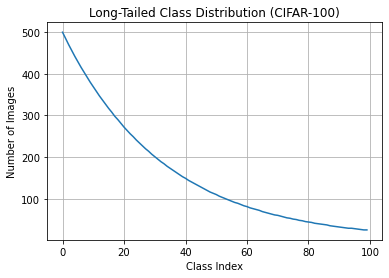

In [7]:
# Get the number of images per class
imgPerClass = []

for cls in range(100):
    num = 500 * (0.05 ** (cls / 99))
    imgPerClass.append(int(num))

print(imgPerClass)
print(np.sum(imgPerClass))
plt.plot(imgPerClass)
plt.xlabel("Class Index")
plt.ylabel("Number of Images")
plt.title("Long-Tailed Class Distribution (CIFAR-100)")
plt.grid(True)
plt.show()

In [8]:
# Get LT training data
trainDataLT, trainLabelLT = [], []
clsList = list(range(100))
random.shuffle(clsList)

for cls, numImg in enumerate(imgPerClass):
    clsIndx = np.where(trainLabel == clsList[cls])[0]
    numSampledImages = np.random.choice(clsIndx, numImg, replace=False)

    trainDataLT.append(trainData[numSampledImages])
    trainLabelLT.append(trainLabel[numSampledImages])

trainDataLT, trainLabelLT = np.concatenate(trainDataLT), np.concatenate(trainLabelLT)

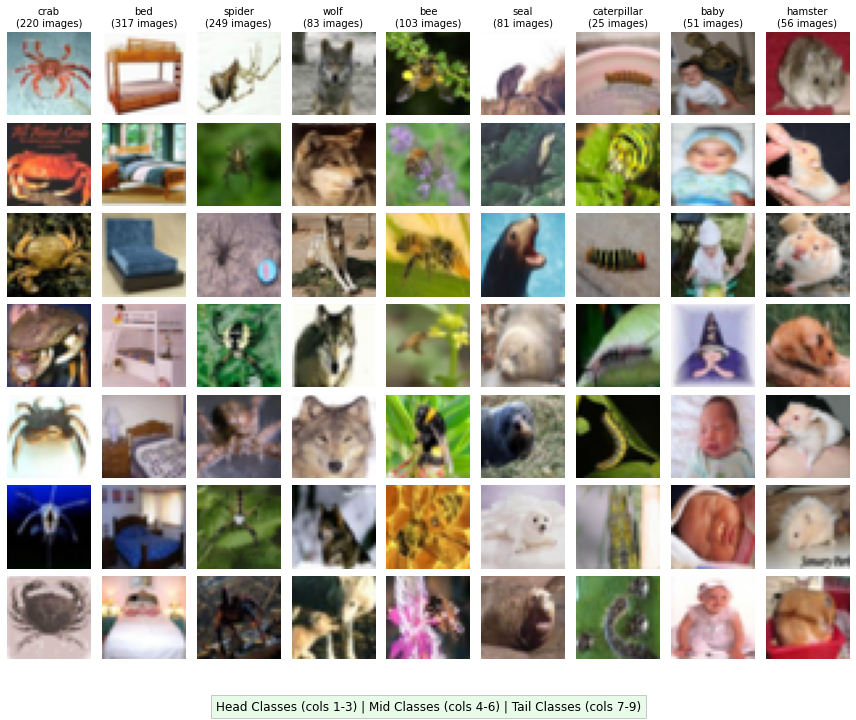

In [9]:
def visualize_long_tail_classes(train_data, train_labels, class_list, class_labels, samples_per_class=7):
    """
    Visualize samples from long-tailed dataset, showing head, mid, and tail classes.
    
    Args:
    - train_data: Training images array in format (N, C, H, W)
    - train_labels: Training labels array
    - class_list: List of class indices 
    - class_labels: Dictionary mapping class indices to class names
    - samples_per_class: Number of samples to show per class
    """
    head_classes = class_list[:30]
    mid_classes = class_list[30:70] 
    tail_classes = class_list[70:]
    
    np.random.seed(42)
    selected_head = np.random.choice(head_classes, 3, replace=False)
    selected_mid = np.random.choice(mid_classes, 3, replace=False)
    selected_tail = np.random.choice(tail_classes, 3, replace=False)
    selected_classes = np.concatenate([selected_head, selected_mid, selected_tail])
    
    plt.figure(figsize=(12, 10))
    for i, class_idx in enumerate(selected_classes):
        idxs = np.flatnonzero(train_labels == class_idx)
        num_found = len(idxs)
        
        if num_found > 0:
            samples_to_show = min(samples_per_class, num_found)
            idxs = np.random.choice(idxs, samples_to_show, replace=False)
            
            for j, idx in enumerate(idxs):
                plt_idx = j * len(selected_classes) + i + 1
                plt.subplot(samples_per_class, len(selected_classes), plt_idx)
                
                img = np.transpose(train_data[idx], (1, 2, 0)).astype('uint8')
                plt.imshow(img)
                plt.axis('off')
                
                if j == 0:
                    if isinstance(class_labels[class_idx], bytes):
                        class_name = class_labels[class_idx].decode('utf-8')
                    else:
                        class_name = class_labels[class_idx]
                    count = np.sum(train_labels == class_idx)
                    plt.title(f"{class_name}\n({count} images)", fontsize=10)
    
    plt.figtext(0.5, 0.01, "Head Classes (cols 1-3) | Mid Classes (cols 4-6) | Tail Classes (cols 7-9)", 
               ha="center", fontsize=12, bbox={"facecolor":"lightgreen", "alpha":0.2, "pad":5})
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08)
    plt.show()

# Example usage:
# For original data:
visualize_long_tail_classes(trainDataLT, trainLabelLT, clsList, classLabels)
# 
# For augmented/generated data:
# visualize_long_tail_classes(augmentedLT, augmentedLabelsLT, clsList, classLabels)

# Training

In [10]:
def plot_training_results(trainLosses, trainAccs, valAccs, batchLosses, freq):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(trainLosses) + 1)
    ax1.plot(epochs, trainLosses, 'b-', label='Training Loss')
    ax1.set_title('Training Loss per Epoch')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='lower left')
    
    batchX = np.arange(len(batchLosses)) * freq
    ax1_inset = ax1.inset_axes([0.55, 0.55, 0.4, 0.4])
    ax1_inset.plot(batchX, batchLosses, 'r-', alpha=0.7)
    ax1_inset.set_title('Batch Losses')

    ax2.plot(epochs, trainAccs, 'g-', label='Training Accuracy')
    ax2.plot(epochs, valAccs, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()
    
    fig.savefig('training_results.png', dpi=300, bbox_inches='tight')

In [11]:
def train_model(trainData, valData, epochs: int, model=None, optimizer=None, scheduler=None, lossFunc=None, freq=200) -> None:
    trainLosses = []
    trainAccs = []
    valAccs = []
    batchLosses = []
    for epoch in range(epochs):
        model.train()
        avgLoss = 0
        batchCorrect = 0
        batchNum = 0
        totalCorrect = 0
        totalNum = 0
        
        epochLosses = []
        for i, batch in tqdm(enumerate(trainData)):
            data, labels = batch
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = lossFunc(output, labels)
            loss.backward()
            optimizer.step()
            
            lossValue = loss.item()
            avgLoss += lossValue
            epochLosses.append(lossValue)
            
            pred = torch.argmax(output, 1)
            batchCorrect += (pred == labels).sum().item()
            totalCorrect += (pred == labels).sum().item()
            totalNum += labels.size(0)
            batchNum += labels.size(0)
            if i % freq == 0:
                avgLossBatch = avgLoss / freq if i > 0 else avgLoss
                accuracy = batchCorrect / batchNum if batchNum > 0 else 0
                batchLosses.append(avgLossBatch)
                avgLoss = 0.0
                batchCorrect = 0.0
                batchNum = 0.0
        
        scheduler.step()
        valAcc, *_ = test_model(model, valData, True)
        trainAcc = totalCorrect / totalNum
        
        meanEpochLoss = np.mean(epochLosses) if epochLosses else 0
        trainLosses.append(meanEpochLoss)
        trainAccs.append(trainAcc)
        valAccs.append(valAcc)
        
        print(f'Epoch {epoch + 1}/{epochs} completed: val acc={valAcc:.3f}, train acc={trainAcc:.3f}, epoch loss={meanEpochLoss:.3f}')
        
        totalCorrect = 0
        totalNum = 0
    
    plot_training_results(trainLosses, trainAccs, valAccs, batchLosses, freq)
    
    return trainLosses, trainAccs, valAccs

# Testing

In [12]:
def test_model(model, dataSet, classAcc=False):

    model.eval()
    correct = 0
    total = 0

    classCorrect = defaultdict(int)
    classTotal = defaultdict(int)

    with torch.no_grad():
        for batch_data in dataSet:
            images, labels = batch_data

            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            predicted = torch.argmax(output, 1)

            for label, pred in zip(labels, predicted):
                classTotal[label.item()] += 1
                if pred == label:
                    classCorrect[label.item()] += 1

                total += 1
                correct += (pred == label).item()

    acc = correct / total

    if classAcc:
        head = clsList[:30]
        mid = clsList[30:70]
        tail = clsList[70:]

        def groupAcc(group):
            return sum(classCorrect[c] for c in group) / sum(classTotal[c] for c in group)

        headAcc = groupAcc(head)
        midAcc = groupAcc(mid)
        tailAcc = groupAcc(tail)

        print(f"Test Accuracy - Overall: {100*acc:.2f}% | Head: {100*headAcc:.2f}% | Mid: {100*midAcc:.2f}% | Tail: {100*tailAcc:.2f}%")
        return acc, headAcc, midAcc, tailAcc

    return acc

# Base Model (ResNet-50)

498it [00:12, 41.09it/s]


Test Accuracy - Overall: 3.57% | Head: 11.63% | Mid: 0.25% | Tail: 0.00%
Epoch 1/20 completed: val acc=0.036, train acc=0.056, epoch loss=4.506


498it [00:11, 43.16it/s]


Test Accuracy - Overall: 3.72% | Head: 12.30% | Mid: 0.13% | Tail: 0.00%
Epoch 2/20 completed: val acc=0.037, train acc=0.103, epoch loss=3.843


498it [00:11, 42.18it/s]


Test Accuracy - Overall: 8.12% | Head: 22.93% | Mid: 3.14% | Tail: 0.08%
Epoch 3/20 completed: val acc=0.081, train acc=0.145, epoch loss=3.593


498it [00:12, 40.16it/s]


Test Accuracy - Overall: 9.20% | Head: 25.19% | Mid: 4.20% | Tail: 0.00%
Epoch 4/20 completed: val acc=0.092, train acc=0.182, epoch loss=3.423


498it [00:11, 43.55it/s]


Test Accuracy - Overall: 11.00% | Head: 29.46% | Mid: 4.77% | Tail: 0.99%
Epoch 5/20 completed: val acc=0.110, train acc=0.208, epoch loss=3.256


498it [00:12, 41.30it/s]


Test Accuracy - Overall: 12.55% | Head: 31.13% | Mid: 7.59% | Tail: 0.74%
Epoch 6/20 completed: val acc=0.126, train acc=0.243, epoch loss=3.091


498it [00:12, 41.38it/s]


Test Accuracy - Overall: 15.55% | Head: 36.65% | Mid: 8.34% | Tail: 4.21%
Epoch 7/20 completed: val acc=0.155, train acc=0.268, epoch loss=2.952


498it [00:12, 41.35it/s]


Test Accuracy - Overall: 16.80% | Head: 37.99% | Mid: 10.66% | Tail: 3.96%
Epoch 8/20 completed: val acc=0.168, train acc=0.299, epoch loss=2.797


498it [00:12, 40.63it/s]


Test Accuracy - Overall: 18.35% | Head: 40.25% | Mid: 12.74% | Tail: 4.13%
Epoch 9/20 completed: val acc=0.183, train acc=0.326, epoch loss=2.637


498it [00:11, 44.00it/s]


Test Accuracy - Overall: 20.28% | Head: 41.34% | Mid: 15.93% | Tail: 5.20%
Epoch 10/20 completed: val acc=0.203, train acc=0.366, epoch loss=2.451


498it [00:10, 46.56it/s]


Test Accuracy - Overall: 20.70% | Head: 39.41% | Mid: 16.75% | Tail: 7.43%
Epoch 11/20 completed: val acc=0.207, train acc=0.412, epoch loss=2.239


498it [00:10, 47.96it/s]


Test Accuracy - Overall: 23.57% | Head: 43.35% | Mid: 20.26% | Tail: 8.42%
Epoch 12/20 completed: val acc=0.236, train acc=0.467, epoch loss=1.985


498it [00:10, 45.44it/s]


Test Accuracy - Overall: 23.62% | Head: 41.67% | Mid: 20.70% | Tail: 9.66%
Epoch 13/20 completed: val acc=0.236, train acc=0.544, epoch loss=1.662


498it [00:11, 43.76it/s]


Test Accuracy - Overall: 25.07% | Head: 43.01% | Mid: 22.46% | Tail: 10.82%
Epoch 14/20 completed: val acc=0.251, train acc=0.637, epoch loss=1.290


498it [00:11, 45.20it/s]


Test Accuracy - Overall: 26.07% | Head: 43.85% | Mid: 23.71% | Tail: 11.64%
Epoch 15/20 completed: val acc=0.261, train acc=0.757, epoch loss=0.884


498it [00:12, 39.84it/s]


Test Accuracy - Overall: 25.90% | Head: 45.44% | Mid: 22.46% | Tail: 11.15%
Epoch 16/20 completed: val acc=0.259, train acc=0.871, epoch loss=0.517


498it [00:11, 44.61it/s]


Test Accuracy - Overall: 26.22% | Head: 43.26% | Mid: 24.22% | Tail: 12.06%
Epoch 17/20 completed: val acc=0.262, train acc=0.942, epoch loss=0.287


498it [00:11, 42.04it/s]


Test Accuracy - Overall: 25.95% | Head: 43.10% | Mid: 24.28% | Tail: 11.23%
Epoch 18/20 completed: val acc=0.260, train acc=0.977, epoch loss=0.171


498it [00:12, 40.73it/s]


Test Accuracy - Overall: 25.90% | Head: 43.26% | Mid: 24.47% | Tail: 10.65%
Epoch 19/20 completed: val acc=0.259, train acc=0.990, epoch loss=0.109


498it [00:12, 40.83it/s]


Test Accuracy - Overall: 25.80% | Head: 43.35% | Mid: 23.90% | Tail: 10.98%
Epoch 20/20 completed: val acc=0.258, train acc=0.993, epoch loss=0.098


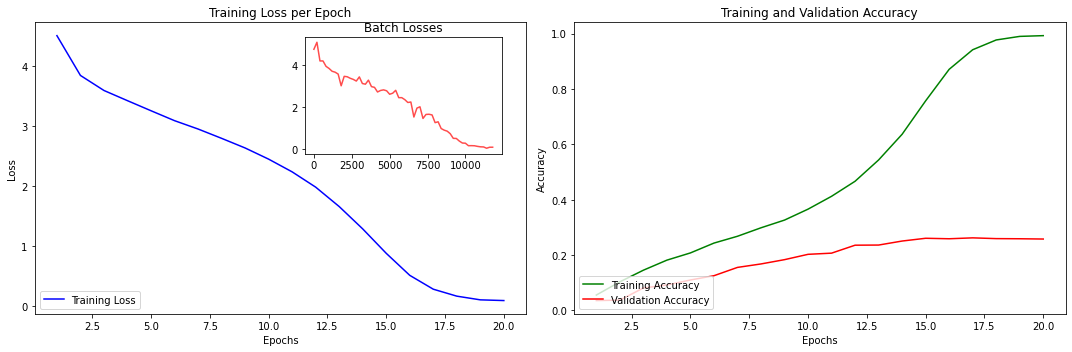

In [26]:
# Cifar-100 LT Accuracy

# Model
model = resnet50(num_classes=100)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(trainDataLT), torch.Tensor(trainLabelLT).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
model.to(device)
lossesLT, trainAccLT, valAccLT = train_model(trainLoader, valLoader, 20, model, optimizer, scheduler, loss)

1563it [00:36, 43.29it/s]


Test Accuracy - Overall: 8.12% | Head: 7.45% | Mid: 7.97% | Tail: 9.00%
Epoch 1/20 completed: val acc=0.081, train acc=0.048, epoch loss=4.326


1563it [00:36, 42.94it/s]


Test Accuracy - Overall: 14.90% | Head: 14.64% | Mid: 13.93% | Tail: 16.43%
Epoch 2/20 completed: val acc=0.149, train acc=0.120, epoch loss=3.704


1563it [00:37, 42.20it/s]


Test Accuracy - Overall: 21.62% | Head: 23.10% | Mid: 18.70% | Tail: 24.03%
Epoch 3/20 completed: val acc=0.216, train acc=0.193, epoch loss=3.303


1563it [00:34, 45.38it/s]


Test Accuracy - Overall: 31.27% | Head: 29.71% | Mid: 30.36% | Tail: 34.02%
Epoch 4/20 completed: val acc=0.313, train acc=0.270, epoch loss=2.901


1563it [00:38, 40.64it/s]


Test Accuracy - Overall: 34.17% | Head: 37.66% | Mid: 32.50% | Tail: 32.95%
Epoch 5/20 completed: val acc=0.342, train acc=0.335, epoch loss=2.586


1563it [00:36, 42.41it/s]


Test Accuracy - Overall: 39.32% | Head: 37.82% | Mid: 37.95% | Tail: 42.61%
Epoch 6/20 completed: val acc=0.393, train acc=0.388, epoch loss=2.340


1563it [00:36, 42.54it/s]


Test Accuracy - Overall: 40.35% | Head: 42.85% | Mid: 37.70% | Tail: 41.37%
Epoch 7/20 completed: val acc=0.404, train acc=0.439, epoch loss=2.102


1563it [00:36, 42.67it/s]


Test Accuracy - Overall: 43.00% | Head: 41.34% | Mid: 41.66% | Tail: 46.41%
Epoch 8/20 completed: val acc=0.430, train acc=0.495, epoch loss=1.848


1563it [00:34, 45.46it/s]


Test Accuracy - Overall: 45.35% | Head: 49.04% | Mid: 41.59% | Tail: 46.66%
Epoch 9/20 completed: val acc=0.454, train acc=0.557, epoch loss=1.584


1563it [00:35, 44.59it/s]


Test Accuracy - Overall: 45.90% | Head: 50.46% | Mid: 43.22% | Tail: 44.92%
Epoch 10/20 completed: val acc=0.459, train acc=0.634, epoch loss=1.276


1563it [00:36, 42.68it/s]


Test Accuracy - Overall: 45.85% | Head: 46.78% | Mid: 44.79% | Tail: 46.33%
Epoch 11/20 completed: val acc=0.459, train acc=0.727, epoch loss=0.931


1563it [00:36, 42.89it/s]


Test Accuracy - Overall: 45.62% | Head: 47.20% | Mid: 42.79% | Tail: 47.81%
Epoch 12/20 completed: val acc=0.456, train acc=0.821, epoch loss=0.601


1563it [00:35, 44.63it/s]


Test Accuracy - Overall: 46.08% | Head: 46.53% | Mid: 45.17% | Tail: 46.82%
Epoch 13/20 completed: val acc=0.461, train acc=0.903, epoch loss=0.330


1563it [00:35, 43.98it/s]


Test Accuracy - Overall: 46.08% | Head: 46.69% | Mid: 43.60% | Tail: 48.72%
Epoch 14/20 completed: val acc=0.461, train acc=0.956, epoch loss=0.164


1563it [00:34, 45.94it/s]


Test Accuracy - Overall: 46.50% | Head: 48.12% | Mid: 44.92% | Tail: 46.99%
Epoch 15/20 completed: val acc=0.465, train acc=0.982, epoch loss=0.083


1563it [00:37, 41.76it/s]


Test Accuracy - Overall: 47.05% | Head: 48.95% | Mid: 46.42% | Tail: 46.00%
Epoch 16/20 completed: val acc=0.470, train acc=0.992, epoch loss=0.046


1563it [00:38, 40.76it/s]


Test Accuracy - Overall: 47.35% | Head: 48.87% | Mid: 45.11% | Tail: 48.80%
Epoch 17/20 completed: val acc=0.473, train acc=0.996, epoch loss=0.026


1563it [00:37, 41.25it/s]


Test Accuracy - Overall: 47.17% | Head: 49.04% | Mid: 44.92% | Tail: 48.31%
Epoch 18/20 completed: val acc=0.472, train acc=0.999, epoch loss=0.016


1563it [00:37, 42.24it/s]


Test Accuracy - Overall: 47.55% | Head: 48.70% | Mid: 45.11% | Tail: 49.63%
Epoch 19/20 completed: val acc=0.475, train acc=0.999, epoch loss=0.012


1563it [00:35, 43.94it/s]


Test Accuracy - Overall: 47.80% | Head: 50.63% | Mid: 44.86% | Tail: 48.89%
Epoch 20/20 completed: val acc=0.478, train acc=0.999, epoch loss=0.009


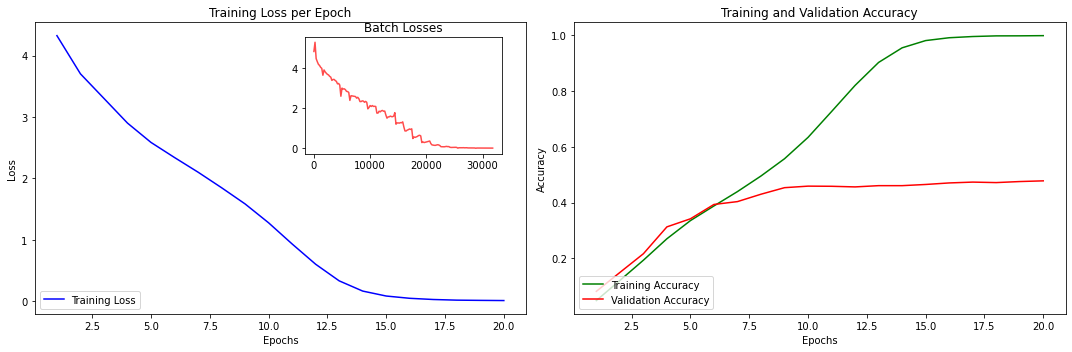

In [27]:
# Cifar-100 Accuracy

# Model
model = resnet50(num_classes=100)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(trainData), torch.Tensor(trainLabel).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
model.to(device)
losses, trainAcc, valAcc = train_model(trainLoader, valLoader, 20, model, optimizer, scheduler, loss)

# Data Augmentation

In [28]:
transformVis = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transformTrain = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

def augment_image(baseImg, forTraining=True):
    imgArray = np.transpose(baseImg, (1, 2, 0))
    img = Image.fromarray(imgArray.astype(np.uint8))
    
    if forTraining:
        return transformTrain(img)
    else:
        return transformVis(img)

In [29]:
augmentedVis = [augment_image(img, forTraining=False) for img in trainDataLT]
augmentedVis = torch.stack(augmentedVis)

augmentedTrain = [augment_image(img) for img in trainDataLT]
augmentedTrain = torch.stack(augmentedTrain)

augmentedVisImages = augmentedVis.numpy() * 255 # ToTensor normalizes between 0-1, so need to multiply by 255
augmentedTrainImages = augmentedTrain.numpy()
augmentedLabels = np.array(trainLabelLT)

(31814, 3, 32, 32) (31814,)


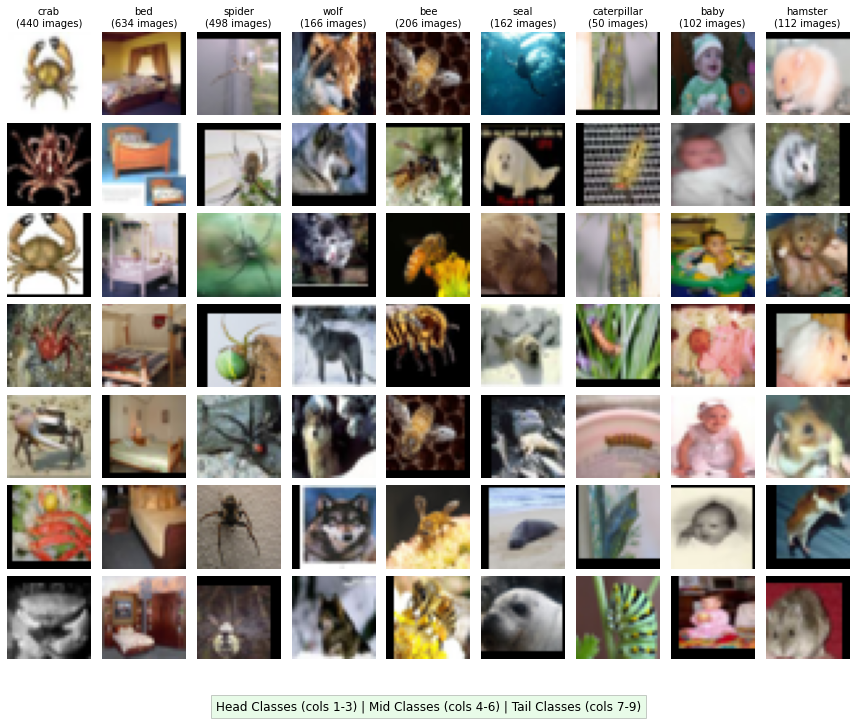

In [30]:
augmentedLT = np.concatenate([trainDataLT, augmentedTrainImages], axis=0)
augmentedLabelsLT = np.concatenate([trainLabelLT, augmentedLabels], axis=0)

print(augmentedLT.shape, augmentedLabelsLT.shape)

augmentedVisLT = np.concatenate([trainDataLT, augmentedVisImages], axis=0)

visualize_long_tail_classes(augmentedVisLT, augmentedLabelsLT, clsList, classLabels)

995it [00:23, 41.56it/s]


Test Accuracy - Overall: 3.38% | Head: 10.88% | Mid: 0.31% | Tail: 0.00%
Epoch 1/20 completed: val acc=0.034, train acc=0.045, epoch loss=4.458


995it [00:23, 42.61it/s]


Test Accuracy - Overall: 5.15% | Head: 16.23% | Mid: 0.75% | Tail: 0.00%
Epoch 2/20 completed: val acc=0.051, train acc=0.084, epoch loss=3.986


995it [00:23, 42.34it/s]


Test Accuracy - Overall: 7.15% | Head: 21.92% | Mid: 1.51% | Tail: 0.00%
Epoch 3/20 completed: val acc=0.071, train acc=0.131, epoch loss=3.699


995it [00:23, 41.64it/s]


Test Accuracy - Overall: 9.15% | Head: 26.11% | Mid: 3.39% | Tail: 0.00%
Epoch 4/20 completed: val acc=0.091, train acc=0.170, epoch loss=3.494


995it [00:23, 41.63it/s]


Test Accuracy - Overall: 13.28% | Head: 29.54% | Mid: 9.41% | Tail: 2.31%
Epoch 5/20 completed: val acc=0.133, train acc=0.206, epoch loss=3.284


995it [00:23, 41.96it/s]


Test Accuracy - Overall: 13.90% | Head: 35.31% | Mid: 6.96% | Tail: 1.90%
Epoch 6/20 completed: val acc=0.139, train acc=0.244, epoch loss=3.083


995it [00:21, 45.63it/s]


Test Accuracy - Overall: 16.98% | Head: 38.58% | Mid: 11.54% | Tail: 2.81%
Epoch 7/20 completed: val acc=0.170, train acc=0.283, epoch loss=2.877


995it [00:23, 41.71it/s]


Test Accuracy - Overall: 20.85% | Head: 42.68% | Mid: 14.62% | Tail: 7.51%
Epoch 8/20 completed: val acc=0.208, train acc=0.334, epoch loss=2.628


995it [00:24, 40.74it/s]


Test Accuracy - Overall: 23.35% | Head: 42.76% | Mid: 20.26% | Tail: 8.26%
Epoch 9/20 completed: val acc=0.234, train acc=0.378, epoch loss=2.396


995it [00:24, 40.54it/s]


Test Accuracy - Overall: 26.22% | Head: 45.94% | Mid: 24.09% | Tail: 9.58%
Epoch 10/20 completed: val acc=0.262, train acc=0.435, epoch loss=2.135


995it [00:24, 40.44it/s]


Test Accuracy - Overall: 28.60% | Head: 47.36% | Mid: 26.54% | Tail: 12.80%
Epoch 11/20 completed: val acc=0.286, train acc=0.498, epoch loss=1.847


995it [00:24, 40.89it/s]


Test Accuracy - Overall: 28.73% | Head: 49.46% | Mid: 25.35% | Tail: 12.72%
Epoch 12/20 completed: val acc=0.287, train acc=0.580, epoch loss=1.507


995it [00:23, 42.81it/s]


Test Accuracy - Overall: 30.68% | Head: 49.21% | Mid: 28.61% | Tail: 15.11%
Epoch 13/20 completed: val acc=0.307, train acc=0.676, epoch loss=1.130


995it [00:22, 43.43it/s]


Test Accuracy - Overall: 30.08% | Head: 47.53% | Mid: 26.60% | Tail: 17.42%
Epoch 14/20 completed: val acc=0.301, train acc=0.785, epoch loss=0.749


995it [00:22, 45.08it/s]


Test Accuracy - Overall: 31.37% | Head: 50.46% | Mid: 29.49% | Tail: 15.03%
Epoch 15/20 completed: val acc=0.314, train acc=0.882, epoch loss=0.435


995it [00:21, 45.80it/s]


Test Accuracy - Overall: 30.03% | Head: 50.29% | Mid: 27.35% | Tail: 13.54%
Epoch 16/20 completed: val acc=0.300, train acc=0.948, epoch loss=0.227


995it [00:22, 44.63it/s]


Test Accuracy - Overall: 30.98% | Head: 49.37% | Mid: 29.67% | Tail: 14.53%
Epoch 17/20 completed: val acc=0.310, train acc=0.979, epoch loss=0.121


995it [00:21, 46.58it/s]


Test Accuracy - Overall: 30.25% | Head: 49.87% | Mid: 27.79% | Tail: 14.12%
Epoch 18/20 completed: val acc=0.302, train acc=0.991, epoch loss=0.075


995it [00:21, 46.41it/s]


Test Accuracy - Overall: 30.93% | Head: 51.05% | Mid: 28.04% | Tail: 14.86%
Epoch 19/20 completed: val acc=0.309, train acc=0.995, epoch loss=0.053


995it [00:22, 44.14it/s]


Test Accuracy - Overall: 30.58% | Head: 50.79% | Mid: 28.04% | Tail: 13.96%
Epoch 20/20 completed: val acc=0.306, train acc=0.997, epoch loss=0.045


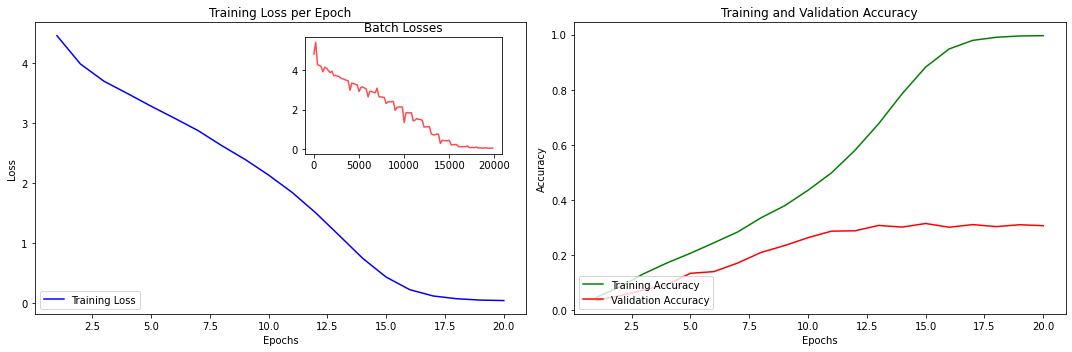

In [31]:
# Cifar-100 Augmented LT Accuracy

# Model
model = resnet50(num_classes=100)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(augmentedLT), torch.Tensor(augmentedLabelsLT).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
model.to(device)
lossesAugLT, trainAccAugLT, valAccAugLT = train_model(trainLoader, valLoader, 20, model, optimizer, scheduler, loss)

# Image Generation

## U-Net Blocks

In [13]:
# U-Net blocks using Group Normalization
class ResidualBlock(nn.Module):
    '''
    A residual block has two convolutional layers with group normalization.
    '''
    def __init__(self, in_channels, out_channels, time_channels=None, num_groups=8):
        '''
        args:
        - in_channels: the number of input channels
        - out_channels: the number of output channels
        - time_channels: the number channels in the time step ($t$) embeddings
        - num_groups: is the number of groups for group normalization
        '''
        super().__init__()
        self.norm1 = nn.GroupNorm(num_groups, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(num_groups, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        # skip connection
        self.skip_connection = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        # time embedding
        self.time_mlp = None
        if time_channels is not None:
            self.time_mlp = nn.Sequential(
                nn.Linear(time_channels, out_channels),
                nn.SiLU()
            )

    def forward(self, x, time_emb=None):
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        if self.time_mlp is not None and time_emb is not None:
            time_condition = self.time_mlp(time_emb)
            h = h + time_condition.view(-1, time_condition.shape[1], 1, 1)
        h = self.norm2(h)
        h = F.silu(h)
        h = self.conv2(h)
        return h + self.skip_connection(x)

In [14]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.norm = nn.GroupNorm(num_groups, in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)

    def forward(self, x):
        x = self.norm(x)
        x = F.silu(x)
        return self.conv(x)

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.norm = nn.GroupNorm(num_groups, in_channels)
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1)

    def forward(self, x):
        x = self.norm(x)
        x = F.silu(x)
        return self.conv(x)

In [15]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

## Lightweight U-Net

In [16]:
class SmallUNet(nn.Module):
    def __init__(self, in_channels=3, time_embedding_dim=128, model_channels=64, num_groups=8):
        super().__init__()
        
        # time embedding
        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbeddings(time_embedding_dim),
            nn.Linear(time_embedding_dim, time_embedding_dim),
            nn.SiLU(),
            nn.Linear(time_embedding_dim, time_embedding_dim),
        )
        
        # initial convolution
        self.input_conv = nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1)
        
        # encoder
        self.enc1 = ResidualBlock(model_channels, model_channels, time_embedding_dim, num_groups)
        self.down1 = DownSample(model_channels, model_channels*2, num_groups)
        self.enc2 = ResidualBlock(model_channels*2, model_channels*2, time_embedding_dim, num_groups)
        self.down2 = DownSample(model_channels*2, model_channels*4, num_groups)
        self.enc3 = ResidualBlock(model_channels*4, model_channels*4, time_embedding_dim, num_groups)
        
        # middle block (latent space)
        self.middle_block1 = ResidualBlock(model_channels*4, model_channels*4, time_embedding_dim, num_groups)
        self.middle_block2 = ResidualBlock(model_channels*4, model_channels*4, time_embedding_dim, num_groups)
        
        # decoder
        self.up1 = UpSample(model_channels*4, model_channels*2, num_groups)
        self.dec1 = ResidualBlock(model_channels*4, model_channels*2, time_embedding_dim, num_groups)
        self.up2 = UpSample(model_channels*2, model_channels, num_groups)
        self.dec2 = ResidualBlock(model_channels*2, model_channels, time_embedding_dim, num_groups)
        self.dec3 = ResidualBlock(model_channels, model_channels, time_embedding_dim, num_groups)
        
        # final layer
        self.final_norm = nn.GroupNorm(num_groups, model_channels)
        self.final_conv = nn.Conv2d(model_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x, time):
        # time embedding
        t = self.time_embedding(time)
        
        # initial convolution
        x = self.input_conv(x)
        
        # encoder
        e1 = self.enc1(x, t)
        x = self.down1(e1)
        e2 = self.enc2(x, t)
        x = self.down2(e2)
        e3 = self.enc3(x, t)
        
        # middle block
        x = self.middle_block1(e3, t)
        x = self.middle_block2(x, t)
        
        # decoder
        x = self.up1(x)
        x = torch.cat([x, e2], dim=1) # skip connection
        x = self.dec1(x, t)
        x = self.up2(x)
        x = torch.cat([x, e1], dim=1) # skip connection
        x = self.dec2(x, t)
        x = self.dec3(x, t)
        
        # final layers
        x = self.final_norm(x)
        x = F.silu(x)
        x = self.final_conv(x)
        return x

## Diffusion Process

In [17]:
class DiffusionModel:
    def __init__(self, model, device, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        """
        Initialize the diffusion model.

        Args:
        - model: U-Net model for denoising
        - device: Device to run the model on
        - timesteps: Number of diffusion steps
        - beta_start: Starting value of noise schedule
        - beta_end: Ending value of noise schedule
        """
        self.model = model
        self.device = device
        self.timesteps = timesteps
        
        # noise schedule
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        
        # calculations for diffusion q(x_t | x_{t-1})
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        
        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)

    def q_sample(self, x_start, t, noise=None):
        """
        Forward diffusion process: Add noise to the image

        Args:
        - x_start: Initial clean image (x_0)
        - t: Timestep
        - noise: Optional pre-generated noise

        Returns:
        - Noisy image at timestep t
        """
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].reshape(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1)

        # apply forward process: q(x_t | x_0) = sqrt(α_cumprod) * x_0 + sqrt(1 - α_cumprod) * ε
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def p_sample(self, x, t, t_index):
        """
        Sample from the model at timestep t

        Args:
        - x: Current noisy image x_t
        - t: Current timestep
        - t_index: Index of the timestep

        Returns:
        - Predicted x_{t-1}
        """
        betas_t = self.betas[t].reshape(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1)
        sqrt_recip_alphas_t = self.sqrt_recip_alphas[t].reshape(-1, 1, 1, 1)
        predicted_noise = self.model(x, t)

        # compute the mean for q(x_{t-1} | x_t, x_0)
        mean = sqrt_recip_alphas_t * (x - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)

        if t_index > 0:
            noise = torch.randn_like(x)
            variance = torch.sqrt(self.posterior_variance[t].reshape(-1, 1, 1, 1))
            return mean + variance * noise
        else:
            return mean

    def p_sample_loop(self, shape):
        """
        Generate samples by running the reverse diffusion process

        Args:
        - shape: Shape of the image to generate

        Returns:
        - Generated image
        """
        self.model.eval()
        with torch.no_grad():
            x = torch.randn(shape).to(self.device)

            # iteratively denoise
            for t_index in reversed(range(self.timesteps)):
                t = torch.full((shape[0],), t_index, device=self.device, dtype=torch.long)
                x = self.p_sample(x, t, t_index)

            x = (x.clamp(-1, 1) + 1) / 2
        return x

    def train_step(self, x_0, optimizer):
        """
        One step of training the diffusion model

        Args:
        - x_0: Clean image
        - optimizer: Optimizer

        Returns:
        - Loss value
        """
        self.model.train()
        optimizer.zero_grad()

        batch_size = x_0.shape[0]
        t = torch.randint(0, self.timesteps, (batch_size,), device=self.device).long()

        noise = torch.randn_like(x_0)
        x_t = self.q_sample(x_0, t, noise)

        predicted_noise = self.model(x_t, t)

        loss = F.mse_loss(predicted_noise, noise)
        loss.backward()

        optimizer.step()
        return loss.item()

## Diffusion Image Generator Class

In [18]:
class DiffusionGenerator:
    def __init__(self, device, timesteps=500, image_size=32, batch_size=5):
        self.device = device
        self.timesteps = timesteps
        self.image_size = image_size
        self.batch_size = batch_size

        self.model = SmallUNet(
            in_channels=3,
            time_embedding_dim=128,
            model_channels=64,
            num_groups=8
        ).to(device)
        self.diffusion = DiffusionModel(self.model, device, timesteps)

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Scale to [-1, 1]
        ])
        self.inverse_transform = transforms.Compose([
            transforms.Normalize((-1, -1, -1), (2, 2, 2)),  # Scale from [-1, 1] to [0, 1]
            transforms.ToPILImage()
        ])
        
        self.train_losses = []
    
    def train(self, class_images, epochs=100, lr=2e-4, verbose=1):
        """
        Train the diffusion model on images from a specific class

        Args:
        - class_images: Array of class images (N, 3, 32, 32)
        - epochs: Number of training epochs
        - lr: Learning rate
        - verbose: whether or not to use print statements
        """
        if not isinstance(class_images, torch.Tensor):
            images = []
            for img in class_images:
                if isinstance(img, np.ndarray):
                    img_tensor = torch.from_numpy(img).float() / 127.5 - 1
                    images.append(img_tensor)
                else:
                    img_tensor = self.transform(img)
                    images.append(img_tensor)
            x_train = torch.stack(images).to(self.device)
        else:
            # if already a tensor, just normalize
            x_train = class_images.to(self.device)
            if x_train.max() > 1.0:
                x_train = x_train / 127.5 - 1

        if len(x_train) < self.batch_size:
            # duplicate data to ensure at least one full batch
            repeat_factor = (self.batch_size // len(x_train)) + 1
            x_train = x_train.repeat(repeat_factor, 1, 1, 1)
            if verbose > 0:
                print(f"Small dataset: {len(class_images)} images. Duplicated to {len(x_train)}.")

        dataset = torch.utils.data.TensorDataset(x_train)
        dataloader = torch.utils.data.DataLoader(
            dataset, batch_size=min(self.batch_size, len(x_train)), shuffle=True
        )

        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs//3, gamma=0.5)

        epoch_losses = []
        if verbose > 0:
            print(f"Training for {epochs} epochs on {len(x_train)} images...")
            
        for epoch in range(epochs):
            total_loss = 0
            num_batches = 0

            for batch in dataloader:
                x = batch[0]
                loss = self.diffusion.train_step(x, optimizer)
                total_loss += loss
                num_batches += 1

            avg_loss = total_loss / num_batches
            epoch_losses.append(avg_loss)
            scheduler.step()

            if verbose > 0 and (epoch % 30 == 0 or epoch == epochs - 1):
                print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
                
        self.train_losses.extend(epoch_losses)
        return epoch_losses

    def generate_images(self, num_images=100, class_idx=None, seed=None):
        """
        Generate new images using the trained diffusion model

        Args:
        - num_images: Number of images to generate
        - class_idx: Class index (for saving purposes)
        - seed: Random seed for reproducibility

        Returns:
        - Array of generated images (num_images, 3, 32, 32) in [0, 1] range
        """
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        all_images = []
        remaining = num_images

        while remaining > 0:
            batch_size = min(self.batch_size, remaining)
            shape = (batch_size, 3, self.image_size, self.image_size)
            batch_images = self.diffusion.p_sample_loop(shape)
            all_images.append(batch_images.cpu())
            remaining -= batch_size

        all_images = torch.cat(all_images, dim=0)
        return all_images.numpy()

    def save_model(self, path):
        """Save model to disk"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'timesteps': self.timesteps,
        }, path)
        print(f"Model saved to {path}")

    def load_model(self, path):
        """Load model from disk"""
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        if 'timesteps' in checkpoint:
            self.timesteps = checkpoint['timesteps']
            self.diffusion = DiffusionModel(self.model, self.device, self.timesteps)
        print(f"Model loaded from {path}")
    
    def plot_training_loss(self):
        """Plot the training loss"""
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses)
        plt.title('Diffusion Model Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('MSE Loss')
        plt.grid(True)
        plt.show()
        
    def visualize_samples(self, num_samples=10, title=None):
        """Visualize generated images"""
        samples = self.generate_images(num_samples)
        samples = samples.transpose(0, 2, 3, 1)
        
        plt.figure(figsize=(15, 5))
        for i in range(min(num_samples, 10)):
            plt.subplot(1, 10, i+1)
            plt.imshow(samples[i])
            plt.axis('off')
        
        if title:
            plt.suptitle(title)
        plt.tight_layout()
        plt.show()

## Image Generation for CIFAR-100 Long-Tail Classes

Identified 99 long-tail classes with fewer than 500 samples:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99]

Processing class 0...
Found 429 real examples
Training for 20 epochs on 429 images...
Epoch 1/20, Loss: 0.3507
Epoch 20/20, Loss: 0.0718
Generating 71 new images for class 0


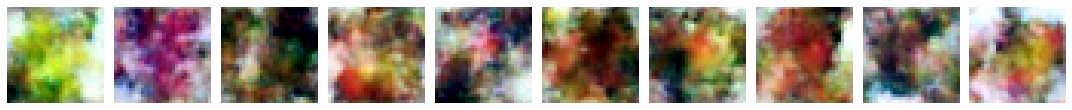


Processing class 1...
Found 144 real examples
Training for 71 epochs on 144 images...
Epoch 1/71, Loss: 0.0931
Epoch 31/71, Loss: 0.0713
Epoch 61/71, Loss: 0.0461
Epoch 71/71, Loss: 0.0570
Generating 356 new images for class 1


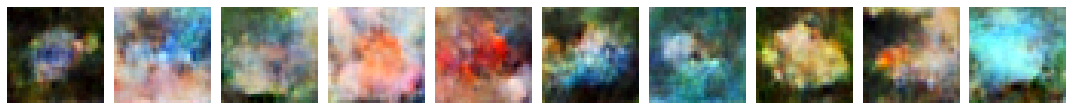


Processing class 2...
Found 51 real examples
Training for 89 epochs on 51 images...
Epoch 1/89, Loss: 0.0708
Epoch 31/89, Loss: 0.0424
Epoch 61/89, Loss: 0.0813
Epoch 89/89, Loss: 0.0471
Generating 449 new images for class 2


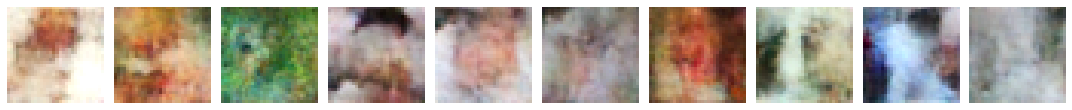


Processing class 3...
Found 25 real examples
Training for 95 epochs on 25 images...
Epoch 1/95, Loss: 0.1157
Epoch 31/95, Loss: 0.0269
Epoch 61/95, Loss: 0.0554
Epoch 91/95, Loss: 0.0297
Epoch 95/95, Loss: 0.0546
Generating 475 new images for class 3


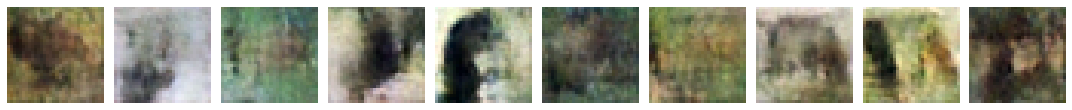


Processing class 4...
Found 184 real examples
Training for 63 epochs on 184 images...
Epoch 1/63, Loss: 0.0534
Epoch 31/63, Loss: 0.0437
Epoch 61/63, Loss: 0.0492
Epoch 63/63, Loss: 0.0433
Generating 316 new images for class 4


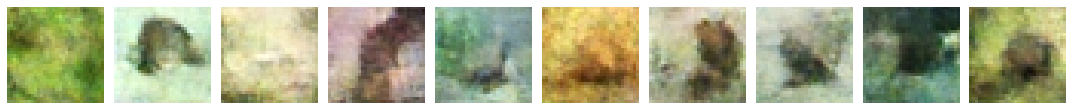


Processing class 5...
Found 317 real examples
Training for 36 epochs on 317 images...
Epoch 1/36, Loss: 0.0722
Epoch 31/36, Loss: 0.0461
Epoch 36/36, Loss: 0.0541
Generating 183 new images for class 5


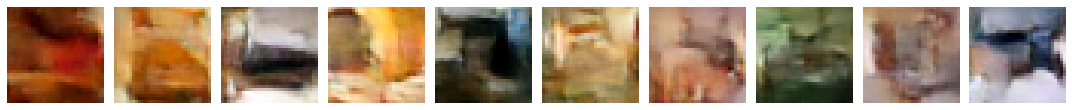


Processing class 6...
Found 103 real examples
Training for 79 epochs on 103 images...
Epoch 1/79, Loss: 0.0671
Epoch 31/79, Loss: 0.0631
Epoch 61/79, Loss: 0.0500
Epoch 79/79, Loss: 0.0460
Generating 397 new images for class 6


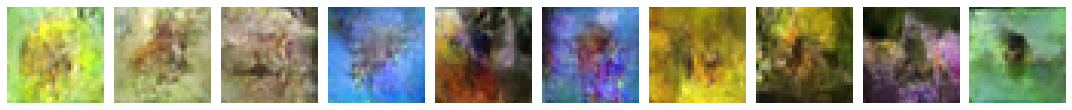


Processing class 7...
Found 106 real examples
Training for 78 epochs on 106 images...
Epoch 1/78, Loss: 0.0563
Epoch 31/78, Loss: 0.0539
Epoch 61/78, Loss: 0.0405
Epoch 78/78, Loss: 0.0447
Generating 394 new images for class 7


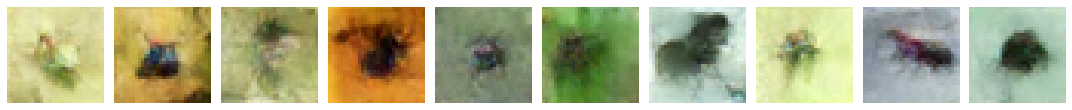


Processing class 8...
Found 29 real examples
Training for 94 epochs on 29 images...
Epoch 1/94, Loss: 0.0894
Epoch 31/94, Loss: 0.0689
Epoch 61/94, Loss: 0.0642
Epoch 91/94, Loss: 0.0270
Epoch 94/94, Loss: 0.0514
Generating 471 new images for class 8


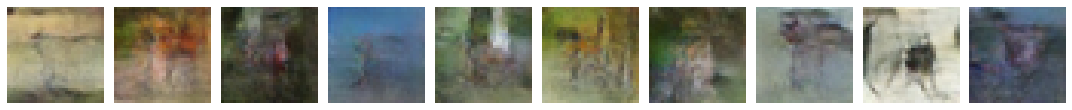


Processing class 9...
Found 48 real examples
Training for 90 epochs on 48 images...
Epoch 1/90, Loss: 0.0605
Epoch 31/90, Loss: 0.0412
Epoch 61/90, Loss: 0.0285
Epoch 90/90, Loss: 0.0376
Generating 452 new images for class 9


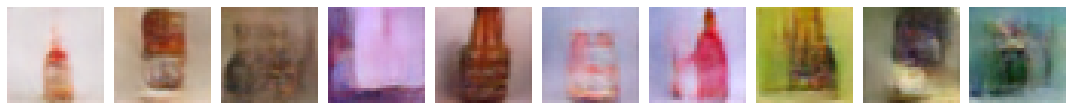


Processing class 10...
Found 456 real examples
Training for 20 epochs on 456 images...
Epoch 1/20, Loss: 0.0626
Epoch 20/20, Loss: 0.0464
Generating 44 new images for class 10


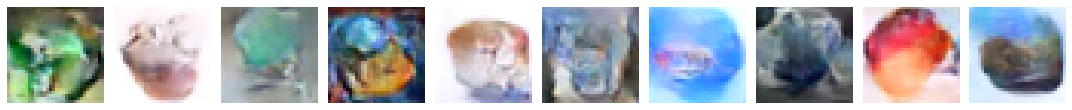


Processing class 11...
Found 168 real examples
Training for 66 epochs on 168 images...
Epoch 1/66, Loss: 0.0579
Epoch 31/66, Loss: 0.0569
Epoch 61/66, Loss: 0.0514
Epoch 66/66, Loss: 0.0514
Generating 332 new images for class 11


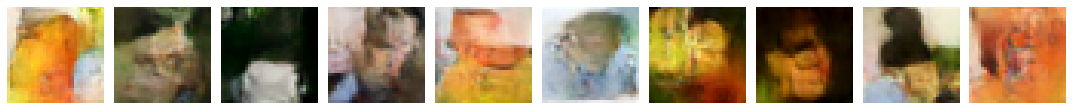


Processing class 12...
Found 69 real examples
Training for 86 epochs on 69 images...
Epoch 1/86, Loss: 0.0569
Epoch 31/86, Loss: 0.0502
Epoch 61/86, Loss: 0.0383
Epoch 86/86, Loss: 0.0231
Generating 431 new images for class 12


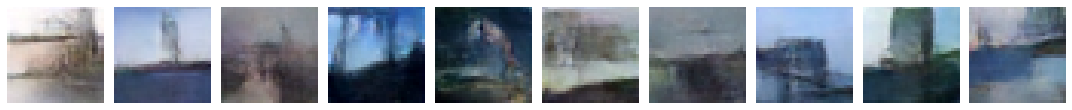


Processing class 13...
Found 30 real examples
Training for 94 epochs on 30 images...
Epoch 1/94, Loss: 0.0843
Epoch 31/94, Loss: 0.0326
Epoch 61/94, Loss: 0.0641
Epoch 91/94, Loss: 0.0360
Epoch 94/94, Loss: 0.0435
Generating 470 new images for class 13


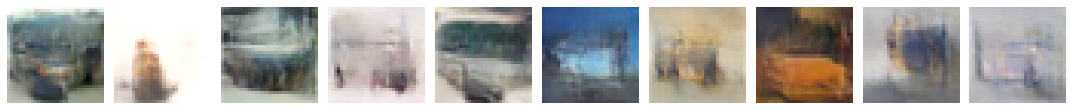


Processing class 14...
Found 281 real examples
Training for 43 epochs on 281 images...
Epoch 1/43, Loss: 0.0836
Epoch 31/43, Loss: 0.0563
Epoch 43/43, Loss: 0.0511
Generating 219 new images for class 14


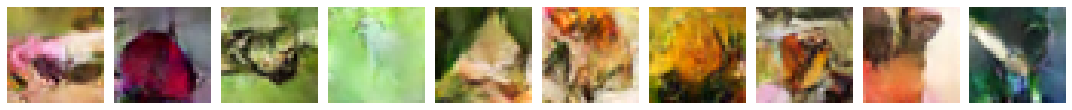


Processing class 15...
Found 61 real examples
Training for 87 epochs on 61 images...
Epoch 1/87, Loss: 0.0521
Epoch 31/87, Loss: 0.0385
Epoch 61/87, Loss: 0.0448
Epoch 87/87, Loss: 0.0357
Generating 439 new images for class 15


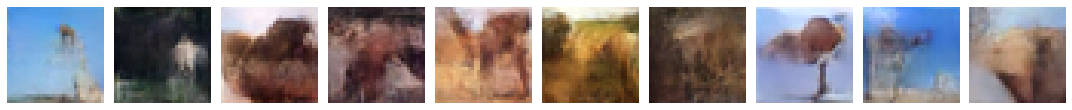


Processing class 16...
Found 207 real examples
Training for 58 epochs on 207 images...
Epoch 1/58, Loss: 0.0558
Epoch 31/58, Loss: 0.0371
Epoch 58/58, Loss: 0.0343
Generating 293 new images for class 16


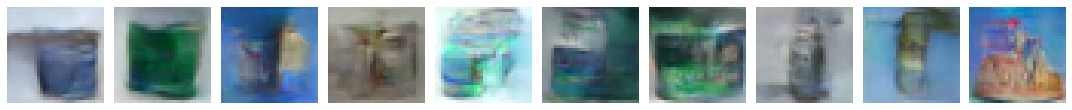


Processing class 18...
Found 25 real examples
Training for 95 epochs on 25 images...
Epoch 1/95, Loss: 0.0576
Epoch 31/95, Loss: 0.0496
Epoch 61/95, Loss: 0.0338
Epoch 91/95, Loss: 0.0382
Epoch 95/95, Loss: 0.0242
Generating 475 new images for class 18


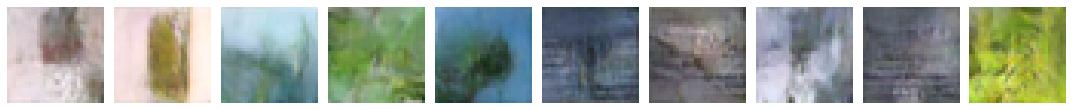


Processing class 19...
Found 41 real examples
Training for 91 epochs on 41 images...
Epoch 1/91, Loss: 0.0833
Epoch 31/91, Loss: 0.0703
Epoch 61/91, Loss: 0.0319
Epoch 91/91, Loss: 0.0153
Generating 459 new images for class 19


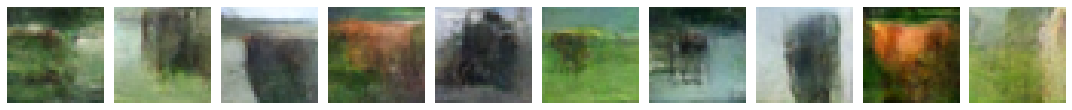


Processing class 20...
Found 100 real examples
Training for 80 epochs on 100 images...
Epoch 1/80, Loss: 0.0646
Epoch 31/80, Loss: 0.0348
Epoch 61/80, Loss: 0.0270
Epoch 80/80, Loss: 0.0263
Generating 400 new images for class 20


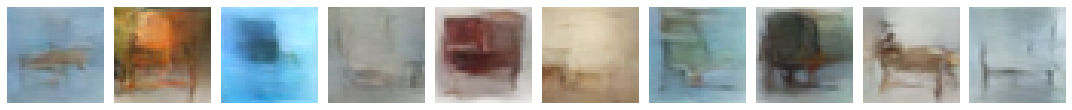


Processing class 21...
Found 32 real examples
Training for 93 epochs on 32 images...
Epoch 1/93, Loss: 0.0654
Epoch 31/93, Loss: 0.0305
Epoch 61/93, Loss: 0.0346
Epoch 91/93, Loss: 0.0179
Epoch 93/93, Loss: 0.0189
Generating 468 new images for class 21


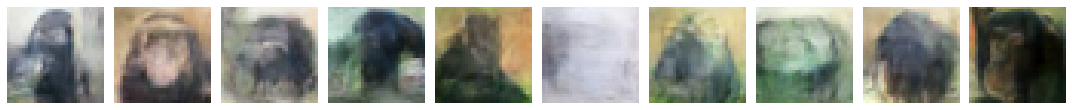


Processing class 22...
Found 298 real examples
Training for 40 epochs on 298 images...
Epoch 1/40, Loss: 0.0680
Epoch 31/40, Loss: 0.0472
Epoch 40/40, Loss: 0.0412
Generating 202 new images for class 22


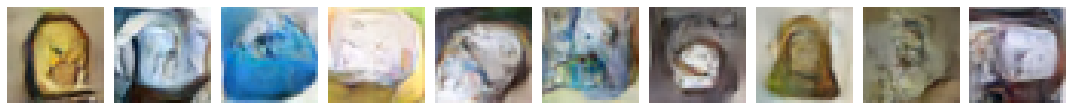


Processing class 23...
Found 43 real examples
Training for 91 epochs on 43 images...
Epoch 1/91, Loss: 0.0247
Epoch 31/91, Loss: 0.0440
Epoch 61/91, Loss: 0.0157
Epoch 91/91, Loss: 0.0152
Generating 457 new images for class 23


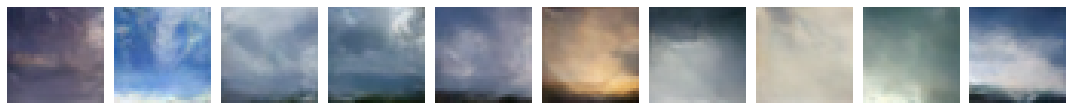


Processing class 24...
Found 40 real examples
Training for 92 epochs on 40 images...
Epoch 1/92, Loss: 0.0428
Epoch 31/92, Loss: 0.0247
Epoch 61/92, Loss: 0.0256
Epoch 91/92, Loss: 0.0276
Epoch 92/92, Loss: 0.0218
Generating 460 new images for class 24


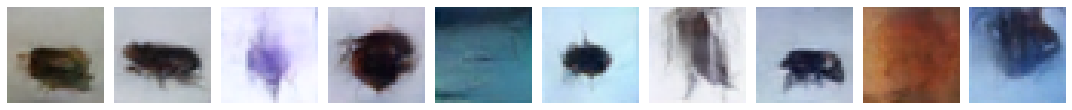


Processing class 25...
Found 54 real examples
Training for 89 epochs on 54 images...
Epoch 1/89, Loss: 0.0533
Epoch 31/89, Loss: 0.0486
Epoch 61/89, Loss: 0.0190
Epoch 89/89, Loss: 0.0175
Generating 446 new images for class 25


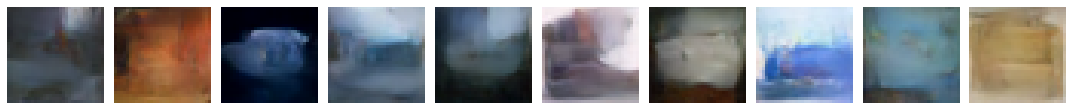


Processing class 26...
Found 220 real examples
Training for 56 epochs on 220 images...
Epoch 1/56, Loss: 0.0670
Epoch 31/56, Loss: 0.0516
Epoch 56/56, Loss: 0.0402
Generating 280 new images for class 26


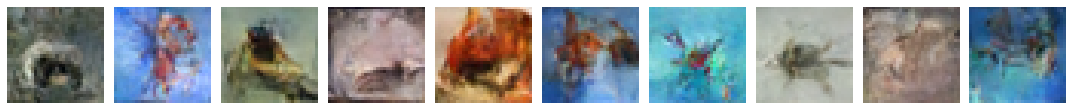


Processing class 27...
Found 94 real examples
Training for 81 epochs on 94 images...
Epoch 1/81, Loss: 0.0521
Epoch 31/81, Loss: 0.0407
Epoch 61/81, Loss: 0.0343
Epoch 81/81, Loss: 0.0318
Generating 406 new images for class 27


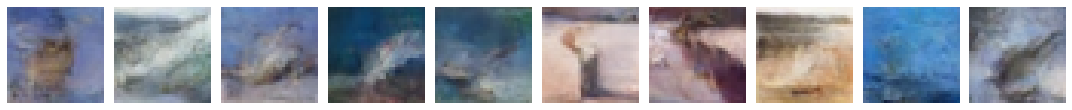


Processing class 28...
Found 47 real examples
Training for 90 epochs on 47 images...
Epoch 1/90, Loss: 0.0417
Epoch 31/90, Loss: 0.0269
Epoch 61/90, Loss: 0.0303
Epoch 90/90, Loss: 0.0200
Generating 453 new images for class 28


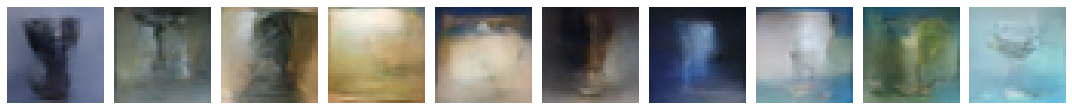


Processing class 29...
Found 136 real examples
Training for 72 epochs on 136 images...
Epoch 1/72, Loss: 0.0476
Epoch 31/72, Loss: 0.0378
Epoch 61/72, Loss: 0.0308
Epoch 72/72, Loss: 0.0400
Generating 364 new images for class 29


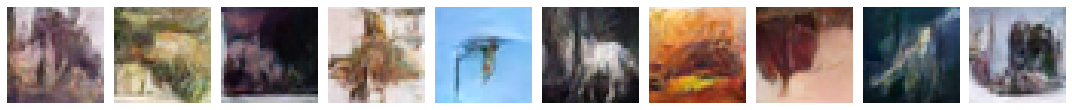


Processing class 30...
Found 124 real examples
Training for 75 epochs on 124 images...
Epoch 1/75, Loss: 0.0408
Epoch 31/75, Loss: 0.0505
Epoch 61/75, Loss: 0.0333
Epoch 75/75, Loss: 0.0334
Generating 376 new images for class 30


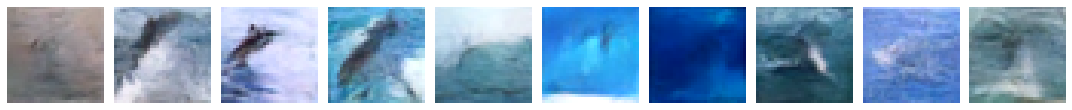


Processing class 31...
Found 347 real examples
Training for 30 epochs on 347 images...
Epoch 1/30, Loss: 0.0623
Epoch 30/30, Loss: 0.0487
Generating 153 new images for class 31


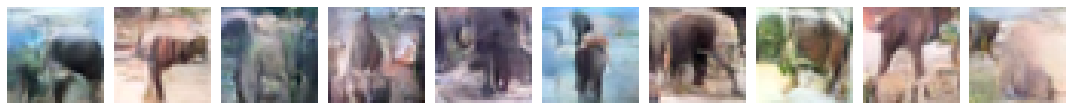


Processing class 32...
Found 470 real examples
Training for 20 epochs on 470 images...
Epoch 1/20, Loss: 0.0514
Epoch 20/20, Loss: 0.0442
Generating 30 new images for class 32


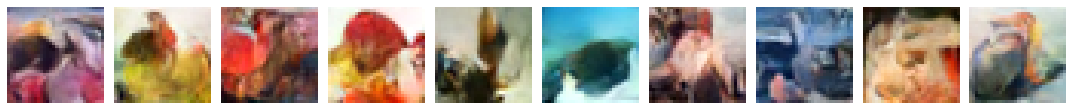


Processing class 33...
Found 65 real examples
Training for 87 epochs on 65 images...
Epoch 1/87, Loss: 0.0517
Epoch 31/87, Loss: 0.0561
Epoch 61/87, Loss: 0.0284
Epoch 87/87, Loss: 0.0537
Generating 435 new images for class 33


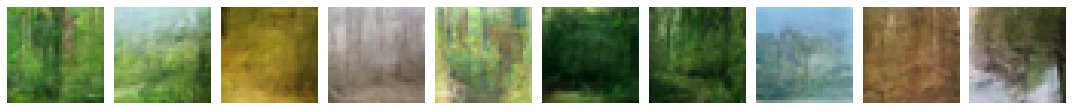


Processing class 34...
Found 380 real examples
Training for 24 epochs on 380 images...
Epoch 1/24, Loss: 0.0525
Epoch 24/24, Loss: 0.0461
Generating 120 new images for class 34


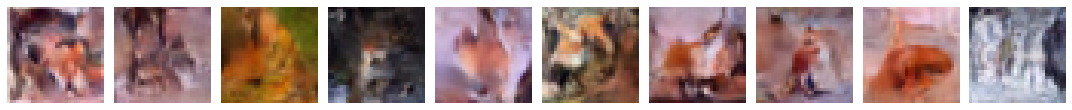


Processing class 35...
Found 110 real examples
Training for 78 epochs on 110 images...
Epoch 1/78, Loss: 0.0561
Epoch 31/78, Loss: 0.0512
Epoch 61/78, Loss: 0.0440
Epoch 78/78, Loss: 0.0273
Generating 390 new images for class 35


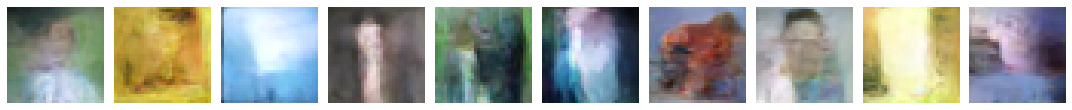


Processing class 36...
Found 56 real examples
Training for 88 epochs on 56 images...
Epoch 1/88, Loss: 0.0513
Epoch 31/88, Loss: 0.0309
Epoch 61/88, Loss: 0.0382
Epoch 88/88, Loss: 0.0193
Generating 444 new images for class 36


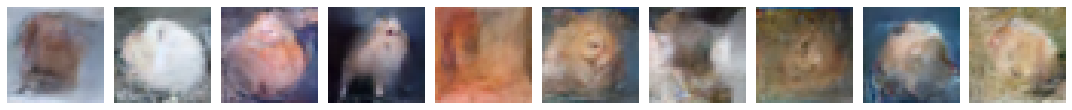


Processing class 37...
Found 58 real examples
Training for 88 epochs on 58 images...
Epoch 1/88, Loss: 0.0725
Epoch 31/88, Loss: 0.0340
Epoch 61/88, Loss: 0.0246
Epoch 88/88, Loss: 0.0347
Generating 442 new images for class 37


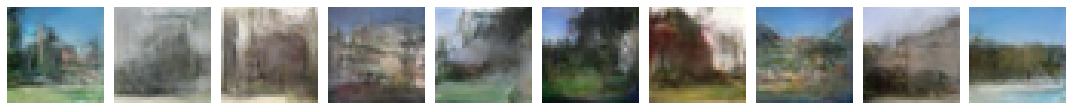


Processing class 38...
Found 31 real examples
Training for 93 epochs on 31 images...
Epoch 1/93, Loss: 0.0477
Epoch 31/93, Loss: 0.0173
Epoch 61/93, Loss: 0.0428
Epoch 91/93, Loss: 0.0215
Epoch 93/93, Loss: 0.0227
Generating 469 new images for class 38


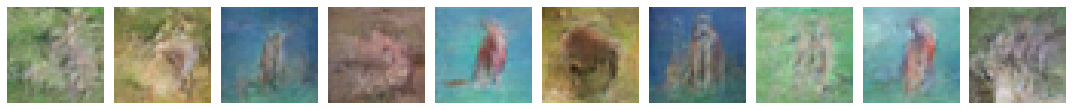


Processing class 39...
Found 91 real examples
Training for 81 epochs on 91 images...
Epoch 1/81, Loss: 0.0764
Epoch 31/81, Loss: 0.0555
Epoch 61/81, Loss: 0.0350
Epoch 81/81, Loss: 0.0289
Generating 409 new images for class 39


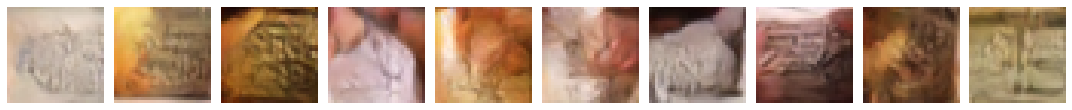


Processing class 40...
Found 37 real examples
Training for 92 epochs on 37 images...
Epoch 1/92, Loss: 0.0556
Epoch 31/92, Loss: 0.0252
Epoch 61/92, Loss: 0.0229
Epoch 91/92, Loss: 0.0277
Epoch 92/92, Loss: 0.0185
Generating 463 new images for class 40


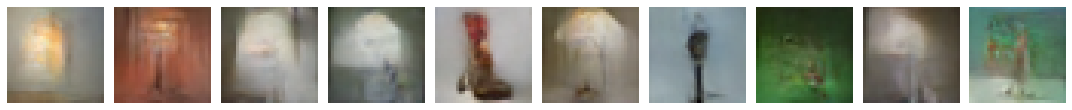


Processing class 41...
Found 392 real examples
Training for 21 epochs on 392 images...
Epoch 1/21, Loss: 0.0514
Epoch 21/21, Loss: 0.0420
Generating 108 new images for class 41


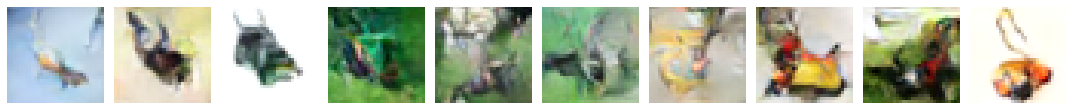


Processing class 42...
Found 241 real examples
Training for 51 epochs on 241 images...
Epoch 1/51, Loss: 0.0672
Epoch 31/51, Loss: 0.0513
Epoch 51/51, Loss: 0.0543
Generating 259 new images for class 42


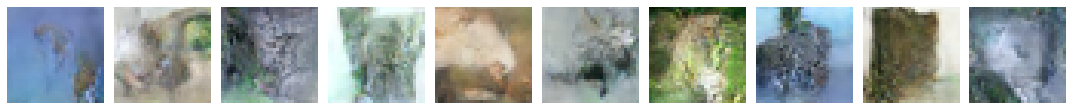


Processing class 43...
Found 227 real examples
Training for 54 epochs on 227 images...
Epoch 1/54, Loss: 0.0546
Epoch 31/54, Loss: 0.0507
Epoch 54/54, Loss: 0.0471
Generating 273 new images for class 43


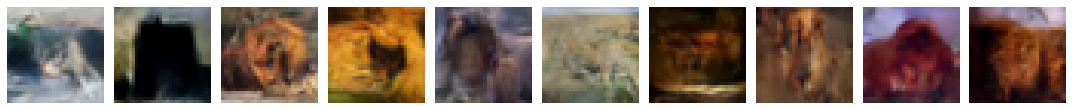


Processing class 44...
Found 214 real examples
Training for 57 epochs on 214 images...
Epoch 1/57, Loss: 0.0471
Epoch 31/57, Loss: 0.0340
Epoch 57/57, Loss: 0.0297
Generating 286 new images for class 44


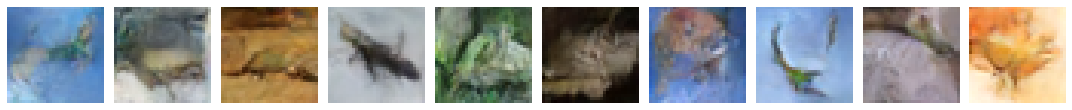


Processing class 45...
Found 178 real examples
Training for 64 epochs on 178 images...
Epoch 1/64, Loss: 0.0579
Epoch 31/64, Loss: 0.0467
Epoch 61/64, Loss: 0.0555
Epoch 64/64, Loss: 0.0504
Generating 322 new images for class 45


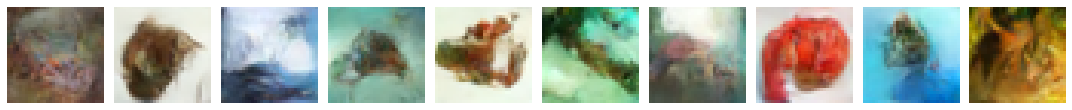


Processing class 46...
Found 140 real examples
Training for 72 epochs on 140 images...
Epoch 1/72, Loss: 0.0576
Epoch 31/72, Loss: 0.0385
Epoch 61/72, Loss: 0.0273
Epoch 72/72, Loss: 0.0338
Generating 360 new images for class 46


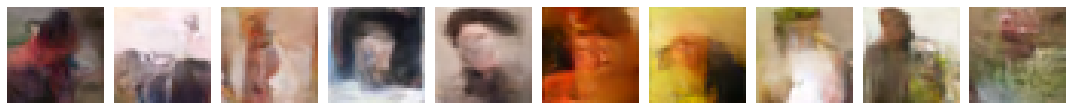


Processing class 47...
Found 163 real examples
Training for 67 epochs on 163 images...
Epoch 1/67, Loss: 0.0654
Epoch 31/67, Loss: 0.0537
Epoch 61/67, Loss: 0.0369
Epoch 67/67, Loss: 0.0438
Generating 337 new images for class 47


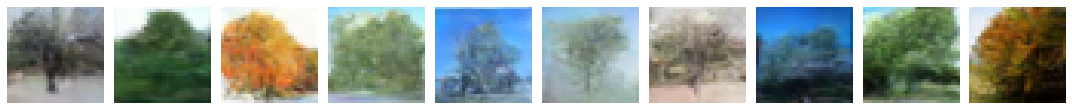


Processing class 48...
Found 173 real examples
Training for 65 epochs on 173 images...
Epoch 1/65, Loss: 0.0622
Epoch 31/65, Loss: 0.0590
Epoch 61/65, Loss: 0.0517
Epoch 65/65, Loss: 0.0580
Generating 327 new images for class 48


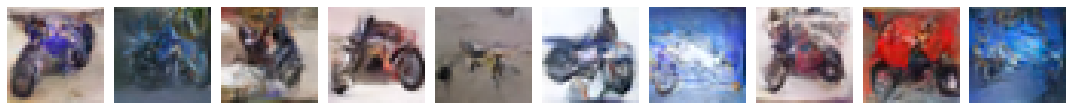


Processing class 49...
Found 38 real examples
Training for 92 epochs on 38 images...
Epoch 1/92, Loss: 0.0322
Epoch 31/92, Loss: 0.0379
Epoch 61/92, Loss: 0.0221
Epoch 91/92, Loss: 0.0125
Epoch 92/92, Loss: 0.0466
Generating 462 new images for class 49


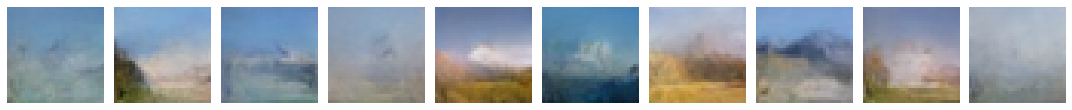


Processing class 50...
Found 60 real examples
Training for 88 epochs on 60 images...
Epoch 1/88, Loss: 0.0675
Epoch 31/88, Loss: 0.0349
Epoch 61/88, Loss: 0.0222
Epoch 88/88, Loss: 0.0243
Generating 440 new images for class 50


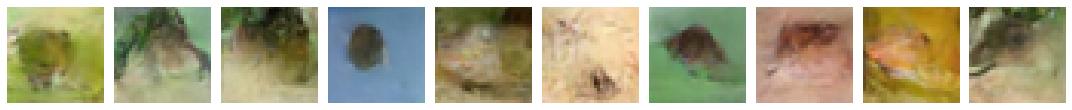


Processing class 51...
Found 195 real examples
Training for 61 epochs on 195 images...
Epoch 1/61, Loss: 0.0502
Epoch 31/61, Loss: 0.0410
Epoch 61/61, Loss: 0.0492
Generating 305 new images for class 51


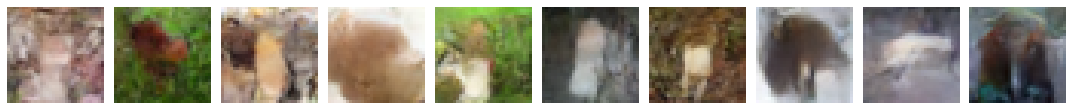


Processing class 52...
Found 358 real examples
Training for 28 epochs on 358 images...
Epoch 1/28, Loss: 0.0524
Epoch 28/28, Loss: 0.0466
Generating 142 new images for class 52


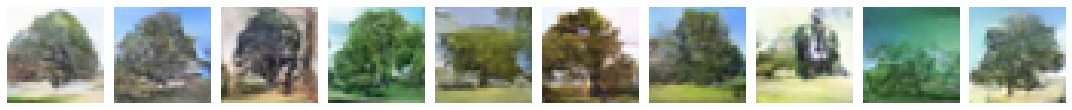


Processing class 53...
Found 86 real examples
Training for 82 epochs on 86 images...
Epoch 1/82, Loss: 0.0583
Epoch 31/82, Loss: 0.0439
Epoch 61/82, Loss: 0.0425
Epoch 82/82, Loss: 0.0326
Generating 414 new images for class 53


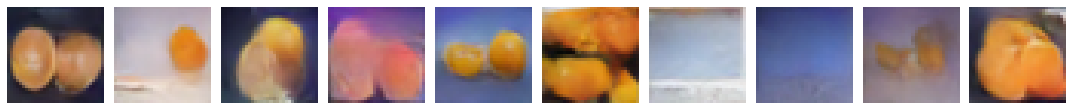


Processing class 54...
Found 404 real examples
Training for 20 epochs on 404 images...
Epoch 1/20, Loss: 0.0642
Epoch 20/20, Loss: 0.0516
Generating 96 new images for class 54


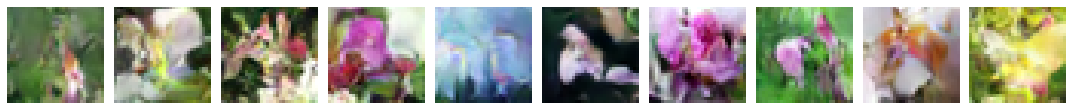


Processing class 55...
Found 27 real examples
Training for 94 epochs on 27 images...
Epoch 1/94, Loss: 0.0855
Epoch 31/94, Loss: 0.0579
Epoch 61/94, Loss: 0.0302
Epoch 91/94, Loss: 0.0416
Epoch 94/94, Loss: 0.0288
Generating 473 new images for class 55


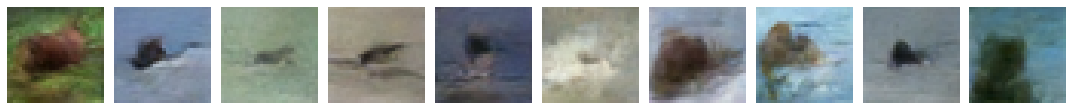


Processing class 56...
Found 33 real examples
Training for 93 epochs on 33 images...
Epoch 1/93, Loss: 0.0527
Epoch 31/93, Loss: 0.0558
Epoch 61/93, Loss: 0.0607
Epoch 91/93, Loss: 0.0337
Epoch 93/93, Loss: 0.0159
Generating 467 new images for class 56


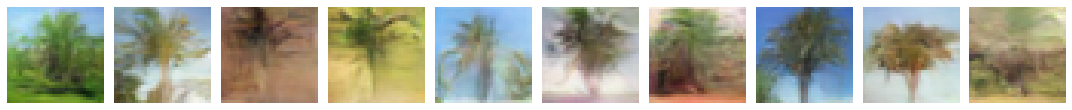


Processing class 57...
Found 189 real examples
Training for 62 epochs on 189 images...
Epoch 1/62, Loss: 0.0548
Epoch 31/62, Loss: 0.0392
Epoch 61/62, Loss: 0.0287
Epoch 62/62, Loss: 0.0468
Generating 311 new images for class 57


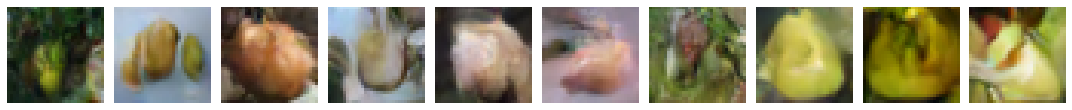


Processing class 58...
Found 442 real examples
Training for 20 epochs on 442 images...
Epoch 1/20, Loss: 0.0543
Epoch 20/20, Loss: 0.0496
Generating 58 new images for class 58


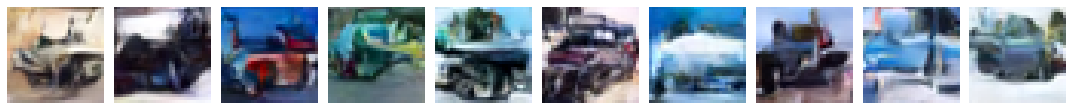


Processing class 59...
Found 264 real examples
Training for 47 epochs on 264 images...
Epoch 1/47, Loss: 0.0512
Epoch 31/47, Loss: 0.0429
Epoch 47/47, Loss: 0.0424
Generating 236 new images for class 59


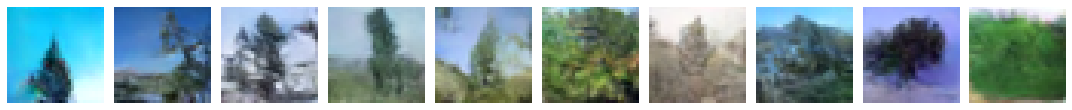


Processing class 60...
Found 149 real examples
Training for 70 epochs on 149 images...
Epoch 1/70, Loss: 0.0383
Epoch 31/70, Loss: 0.0224
Epoch 61/70, Loss: 0.0230
Epoch 70/70, Loss: 0.0315
Generating 351 new images for class 60


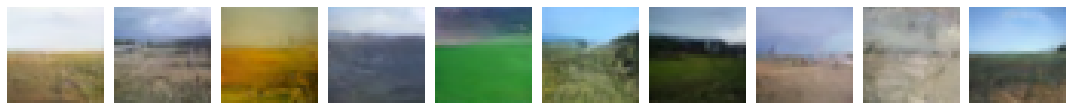


Processing class 61...
Found 327 real examples
Training for 34 epochs on 327 images...
Epoch 1/34, Loss: 0.0498
Epoch 31/34, Loss: 0.0451
Epoch 34/34, Loss: 0.0378
Generating 173 new images for class 61


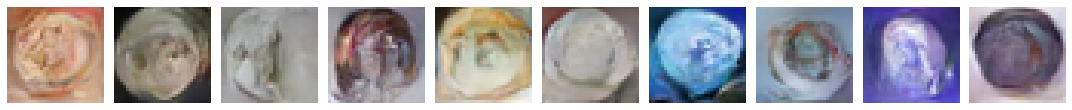


Processing class 62...
Found 234 real examples
Training for 53 epochs on 234 images...
Epoch 1/53, Loss: 0.0647
Epoch 31/53, Loss: 0.0603
Epoch 53/53, Loss: 0.0492
Generating 266 new images for class 62


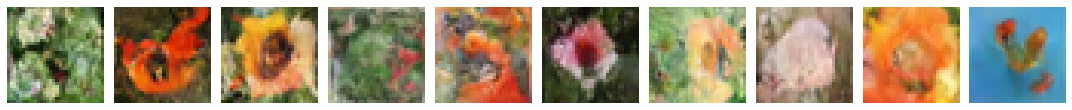


Processing class 63...
Found 39 real examples
Training for 92 epochs on 39 images...
Epoch 1/92, Loss: 0.0406
Epoch 31/92, Loss: 0.0479
Epoch 61/92, Loss: 0.0482
Epoch 91/92, Loss: 0.0288
Epoch 92/92, Loss: 0.0289
Generating 461 new images for class 63


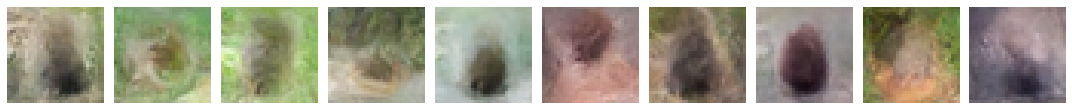


Processing class 64...
Found 78 real examples
Training for 84 epochs on 78 images...
Epoch 1/84, Loss: 0.0676
Epoch 31/84, Loss: 0.0441
Epoch 61/84, Loss: 0.0391
Epoch 84/84, Loss: 0.0468
Generating 422 new images for class 64


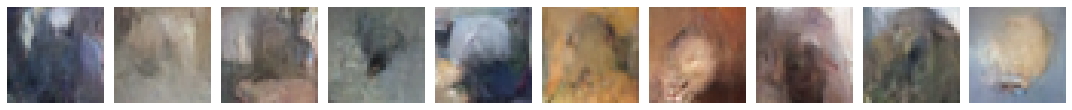


Processing class 65...
Found 29 real examples
Training for 94 epochs on 29 images...
Epoch 1/94, Loss: 0.0738
Epoch 31/94, Loss: 0.0394
Epoch 61/94, Loss: 0.0482
Epoch 91/94, Loss: 0.0258
Epoch 94/94, Loss: 0.0357
Generating 471 new images for class 65


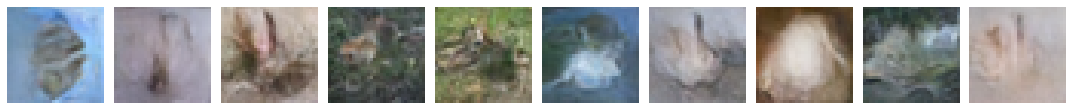


Processing class 66...
Found 272 real examples
Training for 45 epochs on 272 images...
Epoch 1/45, Loss: 0.0453
Epoch 31/45, Loss: 0.0459
Epoch 45/45, Loss: 0.0430
Generating 228 new images for class 66


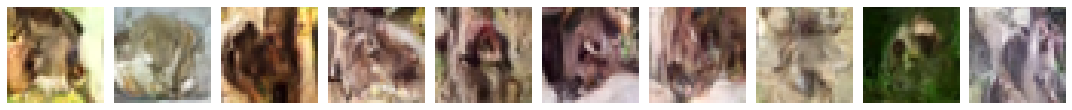


Processing class 67...
Found 113 real examples
Training for 77 epochs on 113 images...
Epoch 1/77, Loss: 0.0380
Epoch 31/77, Loss: 0.0305
Epoch 61/77, Loss: 0.0265
Epoch 77/77, Loss: 0.0279
Generating 387 new images for class 67


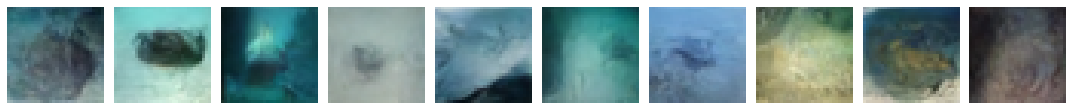


Processing class 68...
Found 63 real examples
Training for 87 epochs on 63 images...
Epoch 1/87, Loss: 0.0323
Epoch 31/87, Loss: 0.0435
Epoch 61/87, Loss: 0.0432
Epoch 87/87, Loss: 0.0136
Generating 437 new images for class 68


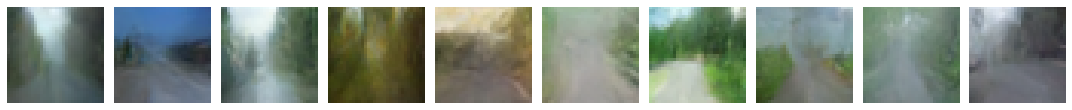


Processing class 69...
Found 28 real examples
Training for 94 epochs on 28 images...
Epoch 1/94, Loss: 0.0401
Epoch 31/94, Loss: 0.0179
Epoch 61/94, Loss: 0.0076
Epoch 91/94, Loss: 0.0216
Epoch 94/94, Loss: 0.0079
Generating 472 new images for class 69


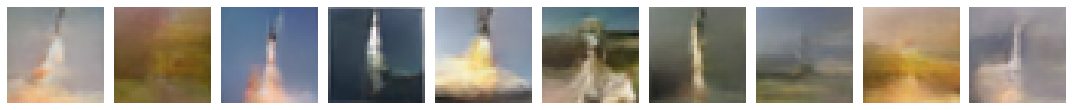


Processing class 70...
Found 128 real examples
Training for 74 epochs on 128 images...
Epoch 1/74, Loss: 0.0575
Epoch 31/74, Loss: 0.0504
Epoch 61/74, Loss: 0.0510
Epoch 74/74, Loss: 0.0368
Generating 372 new images for class 70


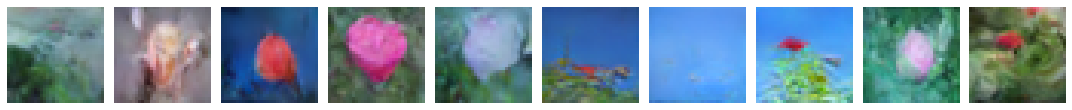


Processing class 71...
Found 76 real examples
Training for 84 epochs on 76 images...
Epoch 1/84, Loss: 0.0276
Epoch 31/84, Loss: 0.0109
Epoch 61/84, Loss: 0.0265
Epoch 84/84, Loss: 0.0231
Generating 424 new images for class 71


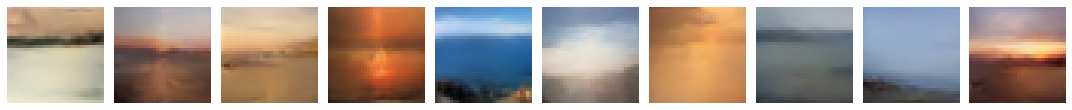


Processing class 72...
Found 81 real examples
Training for 83 epochs on 81 images...
Epoch 1/83, Loss: 0.0497
Epoch 31/83, Loss: 0.0328
Epoch 61/83, Loss: 0.0300
Epoch 83/83, Loss: 0.0250
Generating 419 new images for class 72


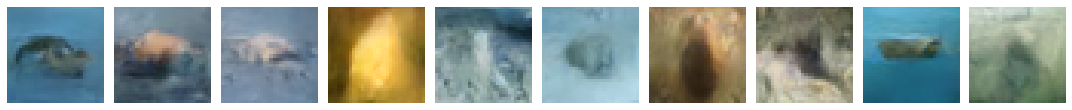


Processing class 73...
Found 132 real examples
Training for 73 epochs on 132 images...
Epoch 1/73, Loss: 0.0392
Epoch 31/73, Loss: 0.0323
Epoch 61/73, Loss: 0.0341
Epoch 73/73, Loss: 0.0343
Generating 368 new images for class 73


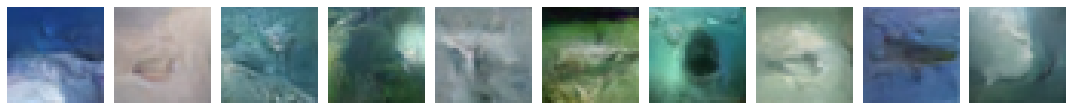


Processing class 74...
Found 153 real examples
Training for 69 epochs on 153 images...
Epoch 1/69, Loss: 0.0591
Epoch 31/69, Loss: 0.0311
Epoch 61/69, Loss: 0.0333
Epoch 69/69, Loss: 0.0401
Generating 347 new images for class 74


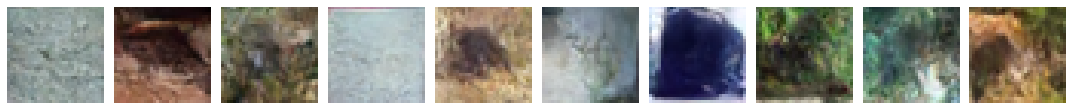


Processing class 75...
Found 35 real examples
Training for 93 epochs on 35 images...
Epoch 1/93, Loss: 0.0574
Epoch 31/93, Loss: 0.0366
Epoch 61/93, Loss: 0.0153
Epoch 91/93, Loss: 0.0248
Epoch 93/93, Loss: 0.0474
Generating 465 new images for class 75


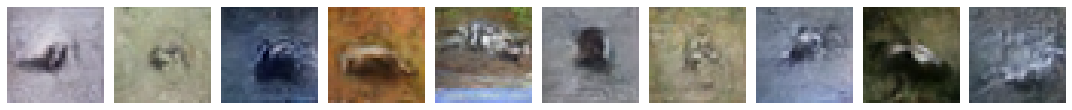


Processing class 76...
Found 308 real examples
Training for 38 epochs on 308 images...
Epoch 1/38, Loss: 0.0431
Epoch 31/38, Loss: 0.0302
Epoch 38/38, Loss: 0.0275
Generating 192 new images for class 76


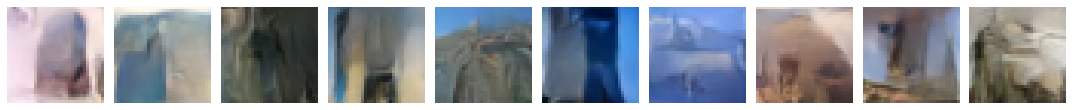


Processing class 77...
Found 72 real examples
Training for 85 epochs on 72 images...
Epoch 1/85, Loss: 0.0316
Epoch 31/85, Loss: 0.0496
Epoch 61/85, Loss: 0.0245
Epoch 85/85, Loss: 0.0574
Generating 428 new images for class 77


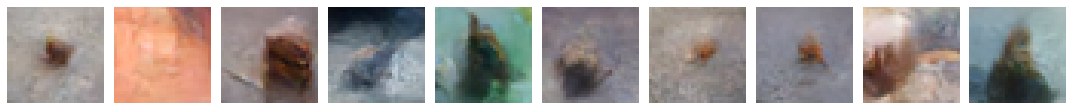


Processing class 78...
Found 89 real examples
Training for 82 epochs on 89 images...
Epoch 1/82, Loss: 0.0544
Epoch 31/82, Loss: 0.0432
Epoch 61/82, Loss: 0.0659
Epoch 82/82, Loss: 0.0329
Generating 411 new images for class 78


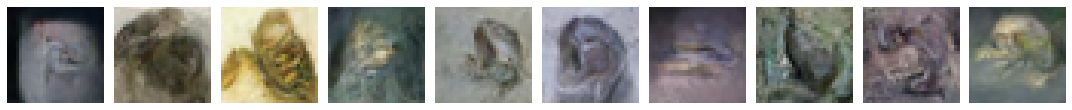


Processing class 79...
Found 249 real examples
Training for 50 epochs on 249 images...
Epoch 1/50, Loss: 0.0366
Epoch 31/50, Loss: 0.0401
Epoch 50/50, Loss: 0.0340
Generating 251 new images for class 79


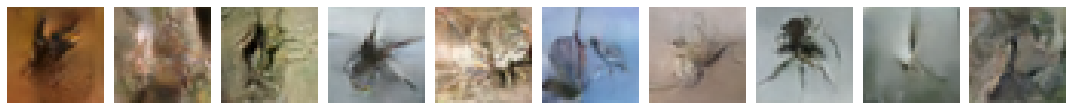


Processing class 80...
Found 53 real examples
Training for 89 epochs on 53 images...
Epoch 1/89, Loss: 0.0464
Epoch 31/89, Loss: 0.0379
Epoch 61/89, Loss: 0.0542
Epoch 89/89, Loss: 0.0197
Generating 447 new images for class 80


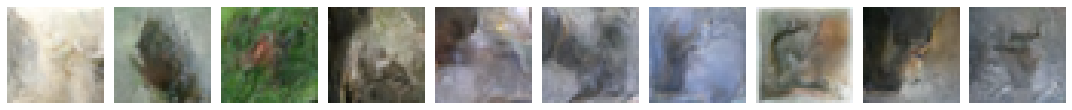


Processing class 81...
Found 290 real examples
Training for 42 epochs on 290 images...
Epoch 1/42, Loss: 0.0703
Epoch 31/42, Loss: 0.0556
Epoch 42/42, Loss: 0.0530
Generating 210 new images for class 81


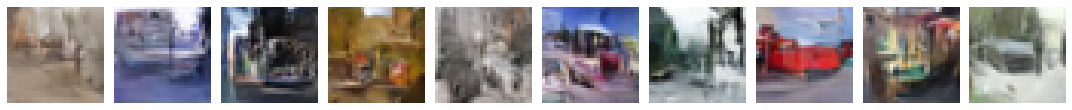


Processing class 82...
Found 44 real examples
Training for 91 epochs on 44 images...
Epoch 1/91, Loss: 0.0661
Epoch 31/91, Loss: 0.0845
Epoch 61/91, Loss: 0.0532
Epoch 91/91, Loss: 0.0408
Generating 456 new images for class 82


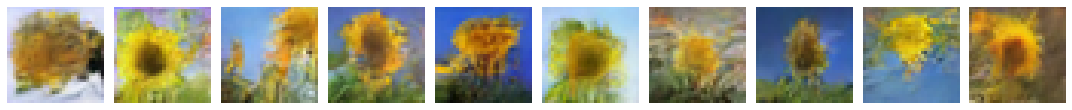


Processing class 83...
Found 369 real examples
Training for 26 epochs on 369 images...
Epoch 1/26, Loss: 0.0604
Epoch 26/26, Loss: 0.0529
Generating 131 new images for class 83


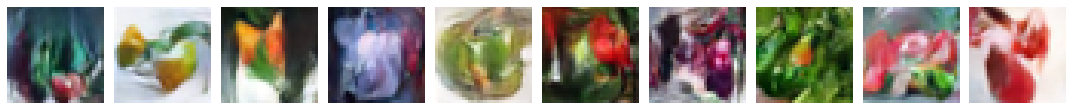


Processing class 84...
Found 201 real examples
Training for 59 epochs on 201 images...
Epoch 1/59, Loss: 0.0531
Epoch 31/59, Loss: 0.0459
Epoch 59/59, Loss: 0.0328
Generating 299 new images for class 84


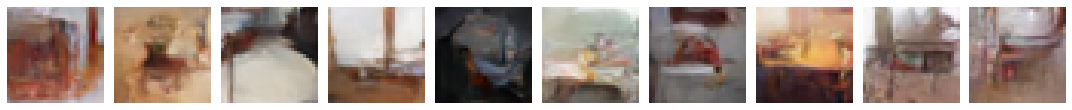


Processing class 85...
Found 116 real examples
Training for 76 epochs on 116 images...
Epoch 1/76, Loss: 0.0419
Epoch 31/76, Loss: 0.0490
Epoch 61/76, Loss: 0.0437
Epoch 76/76, Loss: 0.0313
Generating 384 new images for class 85


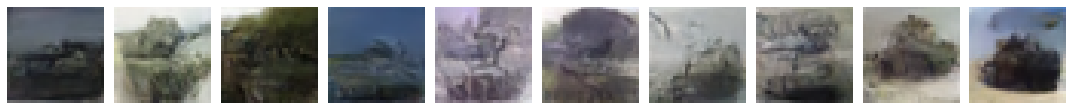


Processing class 86...
Found 26 real examples
Training for 94 epochs on 26 images...
Epoch 1/94, Loss: 0.0443
Epoch 31/94, Loss: 0.0312
Epoch 61/94, Loss: 0.0363
Epoch 91/94, Loss: 0.0259
Epoch 94/94, Loss: 0.0233
Generating 474 new images for class 86


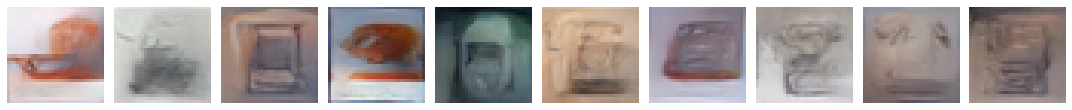


Processing class 87...
Found 45 real examples
Training for 91 epochs on 45 images...
Epoch 1/91, Loss: 0.0526
Epoch 31/91, Loss: 0.0329
Epoch 61/91, Loss: 0.0211
Epoch 91/91, Loss: 0.0217
Generating 455 new images for class 87


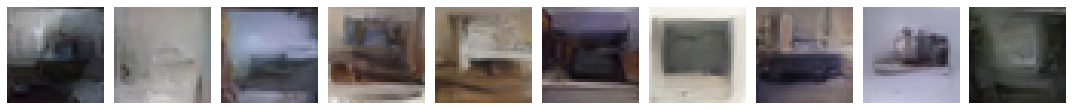


Processing class 88...
Found 34 real examples
Training for 93 epochs on 34 images...
Epoch 1/93, Loss: 0.0840
Epoch 31/93, Loss: 0.0751
Epoch 61/93, Loss: 0.0546
Epoch 91/93, Loss: 0.0348
Epoch 93/93, Loss: 0.0267
Generating 466 new images for class 88


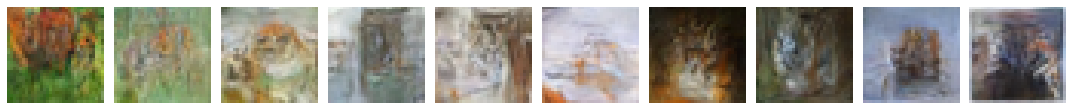


Processing class 89...
Found 97 real examples
Training for 80 epochs on 97 images...
Epoch 1/80, Loss: 0.0758
Epoch 31/80, Loss: 0.0588
Epoch 61/80, Loss: 0.0533
Epoch 80/80, Loss: 0.0617
Generating 403 new images for class 89


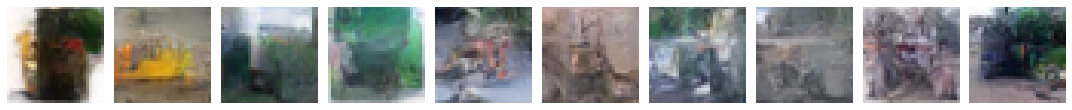


Processing class 90...
Found 337 real examples
Training for 32 epochs on 337 images...
Epoch 1/32, Loss: 0.0494
Epoch 31/32, Loss: 0.0456
Epoch 32/32, Loss: 0.0458
Generating 163 new images for class 90


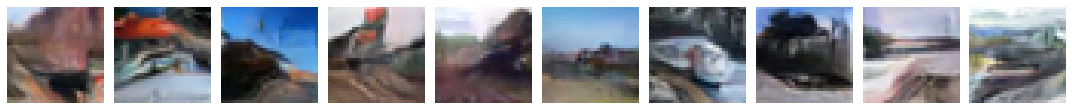


Processing class 91...
Found 74 real examples
Training for 85 epochs on 74 images...
Epoch 1/85, Loss: 0.0404
Epoch 31/85, Loss: 0.0360
Epoch 61/85, Loss: 0.0196
Epoch 85/85, Loss: 0.0244
Generating 426 new images for class 91


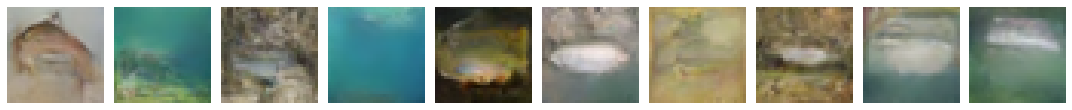


Processing class 92...
Found 67 real examples
Training for 86 epochs on 67 images...
Epoch 1/86, Loss: 0.0649
Epoch 31/86, Loss: 0.0660
Epoch 61/86, Loss: 0.0485
Epoch 86/86, Loss: 0.0331
Generating 433 new images for class 92


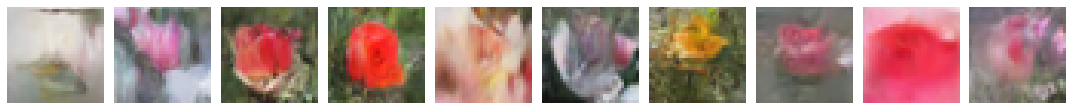


Processing class 93...
Found 120 real examples
Training for 76 epochs on 120 images...
Epoch 1/76, Loss: 0.0646
Epoch 31/76, Loss: 0.0345
Epoch 61/76, Loss: 0.0443
Epoch 76/76, Loss: 0.0318
Generating 380 new images for class 93


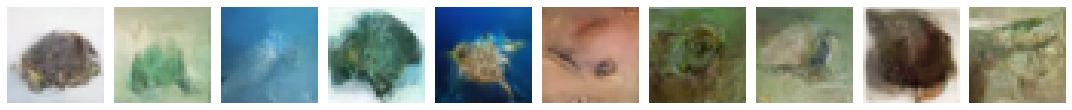


Processing class 94...
Found 50 real examples
Training for 90 epochs on 50 images...
Epoch 1/90, Loss: 0.0538
Epoch 31/90, Loss: 0.0405
Epoch 61/90, Loss: 0.0136
Epoch 90/90, Loss: 0.0148
Generating 450 new images for class 94


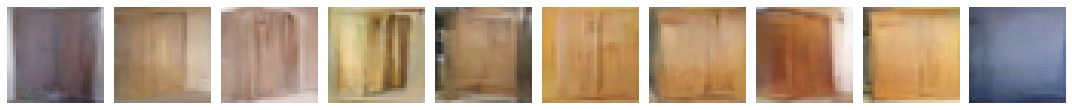


Processing class 95...
Found 485 real examples
Training for 20 epochs on 485 images...
Epoch 1/20, Loss: 0.0423
Epoch 20/20, Loss: 0.0335
Generating 15 new images for class 95


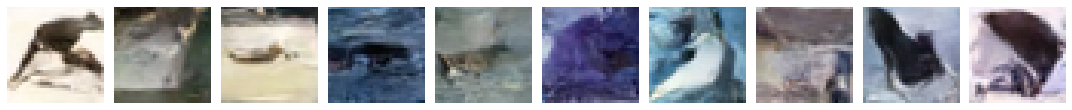


Processing class 96...
Found 158 real examples
Training for 68 epochs on 158 images...
Epoch 1/68, Loss: 0.0435
Epoch 31/68, Loss: 0.0376
Epoch 61/68, Loss: 0.0395
Epoch 68/68, Loss: 0.0349
Generating 342 new images for class 96


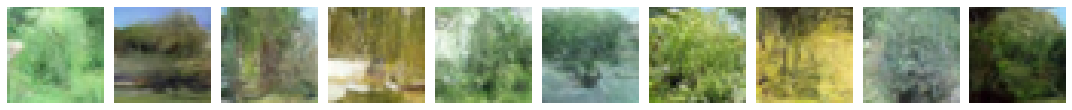


Processing class 97...
Found 83 real examples
Training for 83 epochs on 83 images...
Epoch 1/83, Loss: 0.0539
Epoch 31/83, Loss: 0.0466
Epoch 61/83, Loss: 0.0376
Epoch 83/83, Loss: 0.0249
Generating 417 new images for class 97


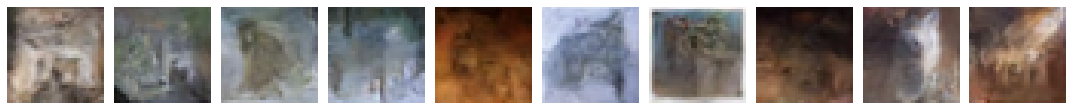


Processing class 98...
Found 256 real examples
Training for 48 epochs on 256 images...
Epoch 1/48, Loss: 0.0508
Epoch 31/48, Loss: 0.0450
Epoch 48/48, Loss: 0.0364
Generating 244 new images for class 98


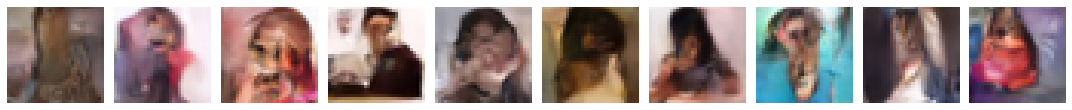


Processing class 99...
Found 416 real examples
Training for 20 epochs on 416 images...
Epoch 1/20, Loss: 0.0363
Epoch 20/20, Loss: 0.0315
Generating 84 new images for class 99


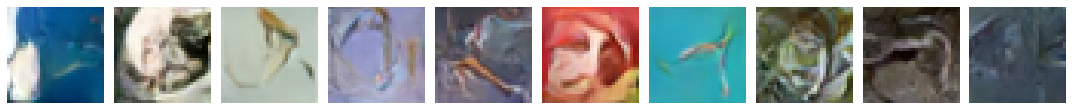

Generated 34093 images across 99 classes
Original dataset size: 15907
Generated dataset size: 50000
Class distribution after generation:
Class 0: 429 → 500
Class 1: 144 → 500
Class 2: 51 → 500
Class 3: 25 → 500
Class 4: 184 → 500
Class 5: 317 → 500
Class 6: 103 → 500
Class 7: 106 → 500
Class 8: 29 → 500
Class 9: 48 → 500
Class 10: 456 → 500
Class 11: 168 → 500
Class 12: 69 → 500
Class 13: 30 → 500
Class 14: 281 → 500
Class 15: 61 → 500
Class 16: 207 → 500
Class 18: 25 → 500
Class 19: 41 → 500
Class 20: 100 → 500
Class 21: 32 → 500
Class 22: 298 → 500
Class 23: 43 → 500
Class 24: 40 → 500
Class 25: 54 → 500
Class 26: 220 → 500
Class 27: 94 → 500
Class 28: 47 → 500
Class 29: 136 → 500
Class 30: 124 → 500
Class 31: 347 → 500
Class 32: 470 → 500
Class 33: 65 → 500
Class 34: 380 → 500
Class 35: 110 → 500
Class 36: 56 → 500
Class 37: 58 → 500
Class 38: 31 → 500
Class 39: 91 → 500
Class 40: 37 → 500
Class 41: 392 → 500
Class 42: 241 → 500
Class 43: 227 → 500
Class 44: 214 → 500
Class 45: 178 

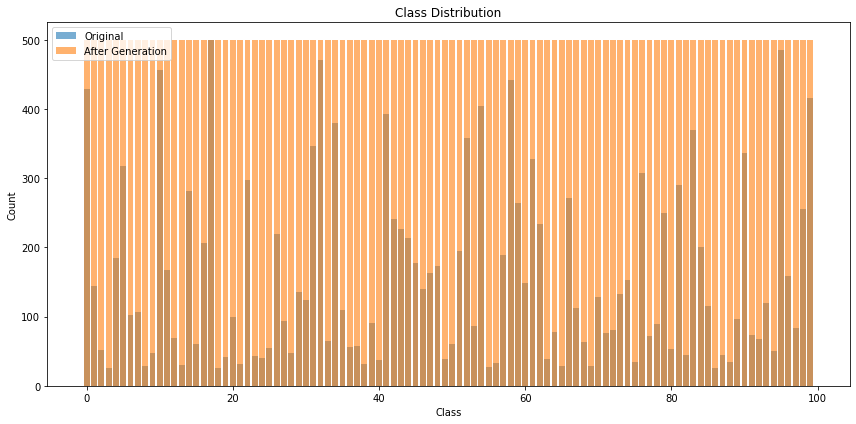

In [23]:
def generate_images_for_tail_classes(train_data, train_labels, long_tail_classes, device,
                                    num_images_target=500, min_epochs=20, max_epochs=100,
                                    batch_size=5, timesteps=500, verbose=1, save_models=False):
    """
    Generate synthetic images for tail classes in CIFAR-100

    Args:
    - train_data: CIFAR-100 training data (n, 3, 32, 32)
    - train_labels: CIFAR-100 training labels (n,)
    - long_tail_classes: List of class indices for tail classes
    - device: Torch device
    - num_images_target: Target number of images per class
    - min_epochs: Minimum number of training epochs
    - max_epochs: Maximum number of training epochs
    - batch_size: Batch size for training and generation
    - timesteps: Number of diffusion timesteps
    - verbose: 3 - class loss plots, 2 - visualize samples, 1 - print lines, 0 - no output
    - save_models: Whether or not to save the trained model

    Returns:
    - Dictionary mapping class indices to arrays of generated images
    """
    generator = DiffusionGenerator(
        device=device,
        timesteps=timesteps,
        image_size=32,
        batch_size=batch_size
    )

    generated_images = {}
    generated_labels = []
    for class_idx in long_tail_classes:
        if verbose > 0:
            print(f"\nProcessing class {class_idx}...")

        mask = train_labels == class_idx
        class_examples = train_data[mask]
        num_examples = len(class_examples)
        
        if verbose > 0:
            print(f"Found {num_examples} real examples")

        if num_examples >= num_images_target:
            if verbose > 0:
                print(f"Class {class_idx} already has {num_examples} examples, skipping.")
            continue

        num_epochs = max(min_epochs, int(max_epochs * (1 - num_examples/num_images_target)))
        
        # train diffusion model on this class
        generator.train(class_examples, epochs=num_epochs, lr=1e-4, verbose=verbose)

        # generate synthetic images
        num_to_generate = num_images_target - num_examples
        if verbose > 0:
            print(f"Generating {num_to_generate} new images for class {class_idx}")
            
        # generate without saving to disk
        synthetic_images = generator.generate_images(
            num_images=num_to_generate,
            class_idx=class_idx
        )

        # visualize loss and samples if verbose
        if verbose > 2:
            generator.plot_training_loss()
        if verbose > 1:
            generator.visualize_samples(10)

        generated_images[class_idx] = synthetic_images
        generated_labels.extend([class_idx] * num_to_generate)

        # save model if requested
        if save_models:
            import os
            save_dir = "models"
            os.makedirs(save_dir, exist_ok=True)
            generator.save_model(f"{save_dir}/diffusion_model_class_{class_idx}.pt")

    if generated_images:
        all_generated_images = np.concatenate([img for img in generated_images.values()], axis=0)
        all_generated_labels = np.array(generated_labels)
        print(f"Generated {len(all_generated_labels)} images across {len(generated_images)} classes")
        return all_generated_images, all_generated_labels
    else:
        print("No images were generated")
        return None, None

def run_generation_pipeline(trainDataLT, trainLabelLT, threshold=100, verbose=1, save_models=False):
    """
    Complete pipeline for generating images for long-tail CIFAR-100 classes

    Args:
    - trainDataLT: long-tail CIFAR-100 training data
    - trainLabelLT: long-tail CIFAR-100 training labels
    - threshold: Classes with fewer than this many samples are considered tail classes
    - verbose: 2 - class distribution, 1 - print lines, 0 - no output
    - save_models: Whether or not to save the trained model

    Returns:
    - Augmented dataset with synthetic images
    """
    class_counts = np.bincount(trainLabelLT, minlength=100)
    long_tail_classes = np.where(class_counts < threshold)[0]
    
    if verbose > 0:
        print(f"Identified {len(long_tail_classes)} long-tail classes with fewer than {threshold} samples:")
        print(long_tail_classes)

    # Generate images
    synthetic_images, synthetic_labels = generate_images_for_tail_classes(
        trainDataLT, trainLabelLT, long_tail_classes, device,
        num_images_target=500,
        min_epochs=20,
        max_epochs=100,
        batch_size=5,
        timesteps=500,
        verbose=verbose,
        save_models=save_models
    )
    
    if synthetic_images is not None:
        # Check if trainDataLT is in [0,255] range
        if trainDataLT.max() > 1.0:
            # Scale generated images to match original data
            synthetic_images = synthetic_images * 255.0
            
        generated_data = np.concatenate([trainDataLT, synthetic_images], axis=0)
        generated_labels = np.concatenate([trainLabelLT, synthetic_labels], axis=0)

        if verbose > 0:
            print(f"Original dataset size: {len(trainDataLT)}")
            print(f"Generated dataset size: {len(generated_data)}")

            # Check class distribution if verbose
            if verbose > 0:
                generated_class_counts = np.bincount(generated_labels, minlength=100)
                print("Class distribution after generation:")
                for i, count in enumerate(generated_class_counts):
                    if i in long_tail_classes:
                        print(f"Class {i}: {class_counts[i]} → {count}")

                # Visualize distributions
                plt.figure(figsize=(12, 6))
                plt.bar(range(100), class_counts, alpha=0.6, label='Original')
                plt.bar(range(100), generated_class_counts, alpha=0.6, label='After Generation')
                plt.xlabel('Class')
                plt.ylabel('Count')
                plt.title('Class Distribution')
                plt.legend()
                plt.tight_layout()
                plt.show()

        return generated_data, generated_labels
    else:
        return trainDataLT, trainLabelLT

generatedLT, generatedLabelLT = run_generation_pipeline(trainDataLT, trainLabelLT, threshold=500, verbose=2)

(50000, 3, 32, 32) (50000,)


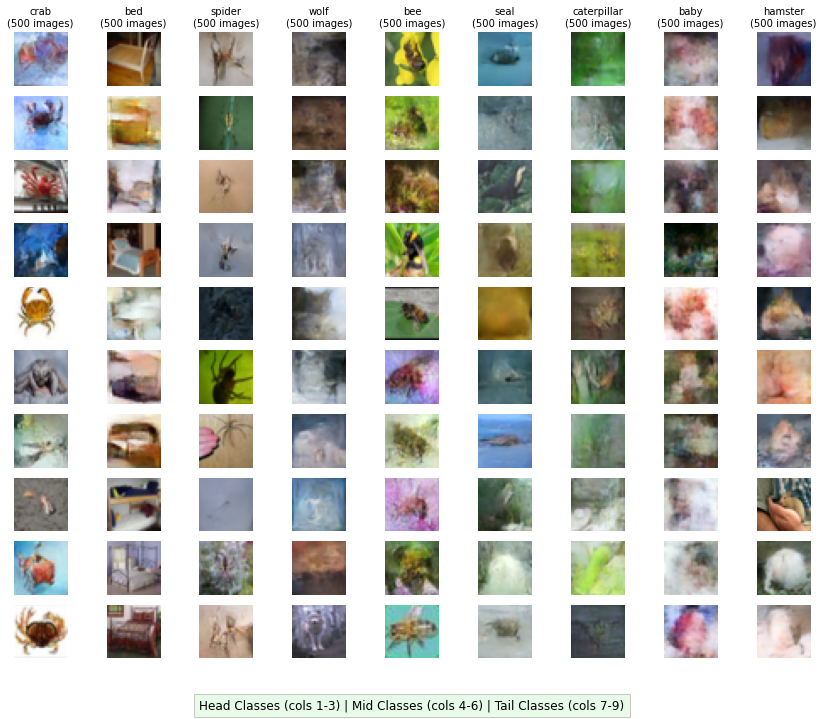

In [32]:
print(generatedLT.shape, generatedLabelLT.shape)
visualize_long_tail_classes(generatedLT, generatedLabelLT, clsList, classLabels, samples_per_class=10)

## Training

1563it [00:34, 45.41it/s]


Test Accuracy - Overall: 3.62% | Head: 6.36% | Mid: 3.26% | Tail: 1.40%
Epoch 1/20 completed: val acc=0.036, train acc=0.024, epoch loss=4.592


1563it [00:33, 46.71it/s]


Test Accuracy - Overall: 8.97% | Head: 15.56% | Mid: 7.09% | Tail: 4.95%
Epoch 2/20 completed: val acc=0.090, train acc=0.082, epoch loss=4.007


1563it [00:33, 46.05it/s]


Test Accuracy - Overall: 12.57% | Head: 20.42% | Mid: 9.72% | Tail: 8.59%
Epoch 3/20 completed: val acc=0.126, train acc=0.210, epoch loss=3.246


1563it [00:35, 44.26it/s]


Test Accuracy - Overall: 17.32% | Head: 28.62% | Mid: 13.24% | Tail: 11.56%
Epoch 4/20 completed: val acc=0.173, train acc=0.343, epoch loss=2.605


1563it [00:33, 47.33it/s]


Test Accuracy - Overall: 21.68% | Head: 33.56% | Mid: 21.08% | Tail: 10.73%
Epoch 5/20 completed: val acc=0.217, train acc=0.484, epoch loss=1.969


1563it [00:33, 46.20it/s]


Test Accuracy - Overall: 24.73% | Head: 40.50% | Mid: 22.08% | Tail: 12.63%
Epoch 6/20 completed: val acc=0.247, train acc=0.592, epoch loss=1.515


1563it [00:34, 45.92it/s]


Test Accuracy - Overall: 26.52% | Head: 42.18% | Mid: 25.28% | Tail: 12.72%
Epoch 7/20 completed: val acc=0.265, train acc=0.675, epoch loss=1.186


1563it [00:37, 41.82it/s]


Test Accuracy - Overall: 25.80% | Head: 44.60% | Mid: 22.90% | Tail: 11.07%
Epoch 8/20 completed: val acc=0.258, train acc=0.746, epoch loss=0.895


1563it [00:36, 42.81it/s]


Test Accuracy - Overall: 28.00% | Head: 46.53% | Mid: 25.28% | Tail: 13.29%
Epoch 9/20 completed: val acc=0.280, train acc=0.813, epoch loss=0.632


1563it [00:32, 47.74it/s]


Test Accuracy - Overall: 29.20% | Head: 49.79% | Mid: 25.22% | Tail: 14.12%
Epoch 10/20 completed: val acc=0.292, train acc=0.878, epoch loss=0.401


1563it [00:37, 42.12it/s]


Test Accuracy - Overall: 28.35% | Head: 45.61% | Mid: 26.66% | Tail: 13.54%
Epoch 11/20 completed: val acc=0.283, train acc=0.932, epoch loss=0.220


1563it [00:34, 44.90it/s]


Test Accuracy - Overall: 28.52% | Head: 48.70% | Mid: 25.22% | Tail: 12.96%
Epoch 12/20 completed: val acc=0.285, train acc=0.965, epoch loss=0.117


1563it [00:36, 42.64it/s]


Test Accuracy - Overall: 28.70% | Head: 48.45% | Mid: 25.78% | Tail: 13.05%
Epoch 13/20 completed: val acc=0.287, train acc=0.981, epoch loss=0.065


1563it [00:38, 40.76it/s]


Test Accuracy - Overall: 29.60% | Head: 48.87% | Mid: 26.22% | Tail: 15.03%
Epoch 14/20 completed: val acc=0.296, train acc=0.992, epoch loss=0.034


1563it [00:37, 42.22it/s]


Test Accuracy - Overall: 29.38% | Head: 49.87% | Mid: 26.04% | Tail: 13.54%
Epoch 15/20 completed: val acc=0.294, train acc=0.995, epoch loss=0.020


1563it [00:37, 41.35it/s]


Test Accuracy - Overall: 29.25% | Head: 49.46% | Mid: 26.60% | Tail: 12.80%
Epoch 16/20 completed: val acc=0.292, train acc=0.998, epoch loss=0.012


1563it [00:37, 42.20it/s]


Test Accuracy - Overall: 29.73% | Head: 51.30% | Mid: 26.41% | Tail: 12.80%
Epoch 17/20 completed: val acc=0.297, train acc=0.999, epoch loss=0.006


1563it [00:36, 42.81it/s]


Test Accuracy - Overall: 30.15% | Head: 51.30% | Mid: 26.54% | Tail: 14.04%
Epoch 18/20 completed: val acc=0.301, train acc=1.000, epoch loss=0.004


1563it [00:34, 45.65it/s]


Test Accuracy - Overall: 30.20% | Head: 52.05% | Mid: 26.04% | Tail: 14.12%
Epoch 19/20 completed: val acc=0.302, train acc=1.000, epoch loss=0.002


1563it [00:36, 42.71it/s]


Test Accuracy - Overall: 30.63% | Head: 51.80% | Mid: 27.23% | Tail: 14.20%
Epoch 20/20 completed: val acc=0.306, train acc=1.000, epoch loss=0.002


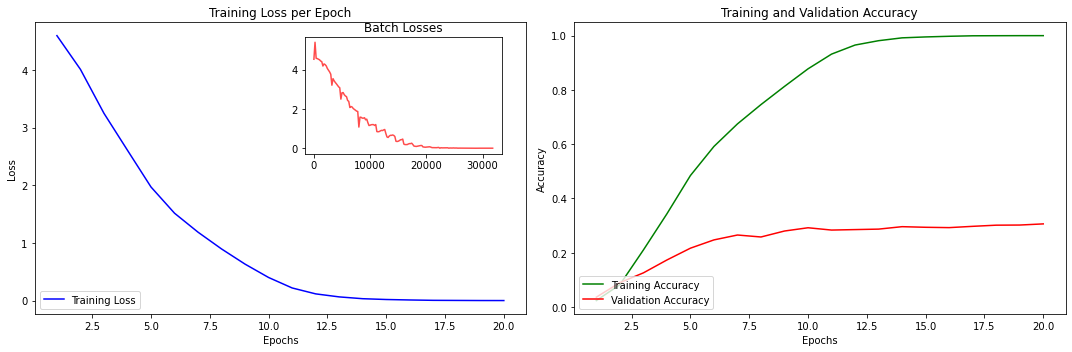

In [25]:
# Cifar-100 Generated LT Accuracy

# Model
model = resnet50(num_classes=100)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(generatedLT), torch.Tensor(generatedLabelLT).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
model.to(device)
lossesGenLT, trainAccGenLT, valAccGenLT = train_model(trainLoader, valLoader, 20, model, optimizer, scheduler, loss)

# DINO Implementation

## Dino/Data Setup

In [33]:
dinoTransform =  transforms.Compose([
        transforms.RandomResizedCrop(32, scale=(0.4, 1.)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

def dinoAugment(baseImg):
    img = Image.fromarray(np.transpose(baseImg, (1, 2, 0)).astype(np.uint8))
    imgAug = dinoTransform(img)
    return imgAug

In [34]:
tempImages = [dinoAugment(img) for img in trainDataLT]
tempImages = torch.stack(tempImages)
dinoImage1 = tempImages.numpy()

tempImages = [dinoAugment(img) for img in trainDataLT]
tempImages = torch.stack(tempImages)
dinoImage2 = tempImages.numpy()

In [35]:
dinoData = torch.utils.data.TensorDataset(torch.tensor(dinoImage1, dtype=torch.float32),
                                          torch.tensor(dinoImage2, dtype=torch.float32))
dinoLoader = torch.utils.data.DataLoader(dinoData, batch_size=128, shuffle=True)

In [36]:
class DINOHead(nn.Module):
    def __init__(self, in_dim, out_dim=65536, hidden_dim=2048, bottleneck_dim=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, bottleneck_dim)
        )
        self.last_layer = nn.utils.weight_norm(nn.Linear(bottleneck_dim, out_dim, bias=False))
        self.last_layer.weight_g.data.fill_(1)
        self.last_layer.weight_g.requires_grad = False  # Freeze the norm

    def forward(self, x):
        x = self.mlp(x)
        return self.last_layer(x)

In [37]:
def dino_loss(student_out, teacher_out, temp_student=0.1, temp_teacher=0.07):
    student_out = torch.nn.functional.log_softmax(student_out / temp_student, dim=-1)
    teacher_out = torch.nn.functional.softmax((teacher_out / temp_teacher).detach(), dim=-1)
    return -torch.mean(torch.sum(teacher_out * student_out, dim=-1))

## Dino Resnet18

In [38]:
class DINOBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = resnet18(pretrained=False)
        self.encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.encoder.fc = nn.Identity()

    def forward(self, x):
        return self.encoder(x)

In [39]:
studentBackbone = DINOBackbone()
teacherBackbone = DINOBackbone()

studentHead = DINOHead(in_dim=512)
teacherHead = DINOHead(in_dim=512)

student = nn.Sequential(studentBackbone, studentHead)
teacher = nn.Sequential(teacherBackbone, teacherHead)

for p in teacher.parameters():
    p.requires_grad = False

/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/javvaji.m/.local/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [40]:
student = student.to(device)
teacher = teacher.to(device)

optimizer = torch.optim.Adam(student.parameters(), lr=1e-3)

for epoch in range(20):
    for view1, view2 in dinoLoader:
        view1, view2 = view1.to(device), view2.to(device)

        student_out = student(view1)
        with torch.no_grad():
            teacher_out = teacher(view2)

        loss = dino_loss(student_out, teacher_out)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # EMA update of teacher
        with torch.no_grad():
            m = 0.996  # Momentum
            for param_q, param_k in zip(student.parameters(), teacher.parameters()):
                param_k.data = param_k.data * m + param_q.data * (1. - m)

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

torch.save(studentBackbone.state_dict(), "dinoBackbone.pth")


Epoch 1, Loss: 10.3669
Epoch 2, Loss: 10.1751
Epoch 3, Loss: 9.7814
Epoch 4, Loss: 9.2089
Epoch 5, Loss: 8.5237
Epoch 6, Loss: 7.3802
Epoch 7, Loss: 5.9284
Epoch 8, Loss: 4.1350
Epoch 9, Loss: 2.3585
Epoch 10, Loss: 1.0961
Epoch 11, Loss: 0.5823
Epoch 12, Loss: 0.2890
Epoch 13, Loss: 0.1480
Epoch 14, Loss: 0.0667
Epoch 15, Loss: 0.0261
Epoch 16, Loss: 0.0082
Epoch 17, Loss: 0.0019
Epoch 18, Loss: 0.0004
Epoch 19, Loss: 0.0001
Epoch 20, Loss: 0.0000


In [41]:
class DinoClassifier(nn.Module):
    def __init__(self, backbone, num_classes=100):
        super().__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

498it [00:06, 80.61it/s]


Test Accuracy - Overall: 8.82% | Head: 27.28% | Mid: 1.69% | Tail: 0.00%
Epoch 1/20 completed: val acc=0.088, train acc=0.133, epoch loss=3.796


498it [00:05, 91.67it/s] 


Test Accuracy - Overall: 15.12% | Head: 40.25% | Mid: 6.90% | Tail: 1.16%
Epoch 2/20 completed: val acc=0.151, train acc=0.250, epoch loss=3.102


498it [00:05, 90.20it/s]


Test Accuracy - Overall: 18.57% | Head: 43.93% | Mid: 11.98% | Tail: 2.23%
Epoch 3/20 completed: val acc=0.186, train acc=0.333, epoch loss=2.692


498it [00:05, 94.76it/s] 


Test Accuracy - Overall: 21.75% | Head: 47.20% | Mid: 16.56% | Tail: 3.47%
Epoch 4/20 completed: val acc=0.217, train acc=0.410, epoch loss=2.319


498it [00:05, 83.01it/s]


Test Accuracy - Overall: 24.50% | Head: 50.54% | Mid: 18.70% | Tail: 6.44%
Epoch 5/20 completed: val acc=0.245, train acc=0.491, epoch loss=1.964


498it [00:05, 90.12it/s] 


Test Accuracy - Overall: 25.07% | Head: 51.80% | Mid: 20.33% | Tail: 4.95%
Epoch 6/20 completed: val acc=0.251, train acc=0.582, epoch loss=1.580


498it [00:05, 85.83it/s]


Test Accuracy - Overall: 26.45% | Head: 50.38% | Mid: 22.77% | Tail: 7.68%
Epoch 7/20 completed: val acc=0.265, train acc=0.692, epoch loss=1.189


498it [00:06, 78.80it/s]


Test Accuracy - Overall: 26.72% | Head: 47.87% | Mid: 25.03% | Tail: 8.09%
Epoch 8/20 completed: val acc=0.267, train acc=0.804, epoch loss=0.823


498it [00:05, 91.17it/s] 


Test Accuracy - Overall: 27.70% | Head: 47.87% | Mid: 24.84% | Tail: 11.56%
Epoch 9/20 completed: val acc=0.277, train acc=0.878, epoch loss=0.550


498it [00:05, 90.37it/s] 


Test Accuracy - Overall: 27.45% | Head: 47.45% | Mid: 24.34% | Tail: 11.81%
Epoch 10/20 completed: val acc=0.275, train acc=0.935, epoch loss=0.363


498it [00:05, 91.37it/s] 


Test Accuracy - Overall: 28.43% | Head: 48.62% | Mid: 25.91% | Tail: 11.81%
Epoch 11/20 completed: val acc=0.284, train acc=0.959, epoch loss=0.255


498it [00:05, 86.04it/s] 


Test Accuracy - Overall: 28.10% | Head: 48.28% | Mid: 25.41% | Tail: 11.73%
Epoch 12/20 completed: val acc=0.281, train acc=0.973, epoch loss=0.181


498it [00:05, 91.93it/s] 


Test Accuracy - Overall: 28.62% | Head: 49.96% | Mid: 24.59% | Tail: 12.88%
Epoch 13/20 completed: val acc=0.286, train acc=0.981, epoch loss=0.133


498it [00:05, 96.63it/s] 


Test Accuracy - Overall: 28.35% | Head: 48.95% | Mid: 24.65% | Tail: 12.88%
Epoch 14/20 completed: val acc=0.283, train acc=0.987, epoch loss=0.106


498it [00:05, 91.16it/s] 


Test Accuracy - Overall: 28.18% | Head: 48.54% | Mid: 24.97% | Tail: 12.30%
Epoch 15/20 completed: val acc=0.282, train acc=0.989, epoch loss=0.085


498it [00:05, 95.26it/s] 


Test Accuracy - Overall: 28.82% | Head: 49.37% | Mid: 25.28% | Tail: 13.21%
Epoch 16/20 completed: val acc=0.288, train acc=0.993, epoch loss=0.068


498it [00:05, 84.32it/s]


Test Accuracy - Overall: 28.80% | Head: 49.21% | Mid: 25.35% | Tail: 13.21%
Epoch 17/20 completed: val acc=0.288, train acc=0.994, epoch loss=0.063


498it [00:05, 89.00it/s] 


Test Accuracy - Overall: 28.38% | Head: 48.12% | Mid: 25.09% | Tail: 13.21%
Epoch 18/20 completed: val acc=0.284, train acc=0.996, epoch loss=0.056


498it [00:05, 87.68it/s] 


Test Accuracy - Overall: 28.68% | Head: 49.29% | Mid: 25.16% | Tail: 12.96%
Epoch 19/20 completed: val acc=0.287, train acc=0.995, epoch loss=0.051


498it [00:06, 79.48it/s]


Test Accuracy - Overall: 28.55% | Head: 48.45% | Mid: 25.35% | Tail: 13.13%
Epoch 20/20 completed: val acc=0.285, train acc=0.996, epoch loss=0.048


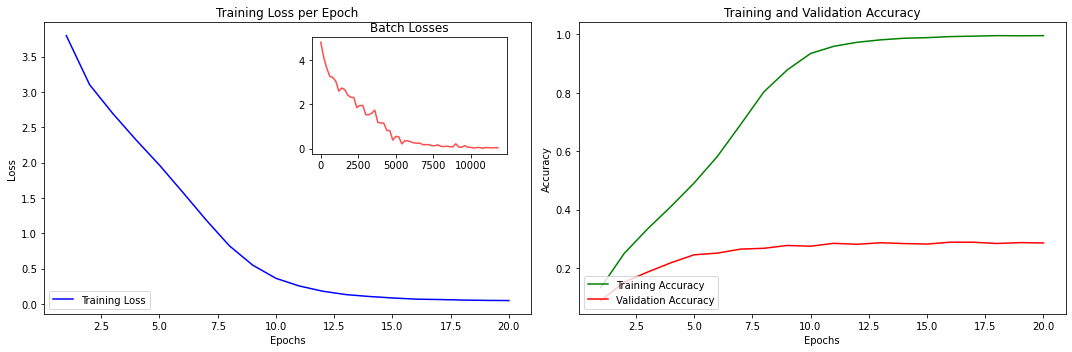

In [42]:
# Model
backbone = DINOBackbone()
backbone.load_state_dict(torch.load("dinoBackbone.pth"))
modelDino = DinoClassifier(backbone)

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(trainDataLT), torch.Tensor(trainLabelLT).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(modelDino.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
modelDino.to(device)
lossesDINOLT, trainAccDINOLT, valAccDINOLT = train_model(trainLoader, valLoader, 20, modelDino, optimizer, scheduler, loss)

/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
995it [00:10, 90.61it/s] 


Test Accuracy - Overall: 7.30% | Head: 22.18% | Mid: 1.69% | Tail: 0.00%
Epoch 1/20 completed: val acc=0.073, train acc=0.093, epoch loss=3.967


995it [00:10, 95.64it/s] 


Test Accuracy - Overall: 13.20% | Head: 35.48% | Mid: 6.40% | Tail: 0.17%
Epoch 2/20 completed: val acc=0.132, train acc=0.164, epoch loss=3.523


995it [00:11, 88.87it/s]


Test Accuracy - Overall: 17.57% | Head: 40.25% | Mid: 12.61% | Tail: 1.73%
Epoch 3/20 completed: val acc=0.176, train acc=0.230, epoch loss=3.188


995it [00:10, 98.15it/s] 


Test Accuracy - Overall: 20.82% | Head: 45.86% | Mid: 15.68% | Tail: 2.89%
Epoch 4/20 completed: val acc=0.208, train acc=0.287, epoch loss=2.885


995it [00:10, 95.91it/s] 


Test Accuracy - Overall: 24.27% | Head: 48.12% | Mid: 20.33% | Tail: 5.95%
Epoch 5/20 completed: val acc=0.243, train acc=0.336, epoch loss=2.631


995it [00:12, 81.27it/s]


Test Accuracy - Overall: 25.30% | Head: 51.21% | Mid: 21.14% | Tail: 5.20%
Epoch 6/20 completed: val acc=0.253, train acc=0.389, epoch loss=2.384


995it [00:11, 88.76it/s]


Test Accuracy - Overall: 27.18% | Head: 50.46% | Mid: 25.35% | Tail: 6.61%
Epoch 7/20 completed: val acc=0.272, train acc=0.448, epoch loss=2.126


995it [00:11, 85.78it/s] 


Test Accuracy - Overall: 29.07% | Head: 51.13% | Mid: 26.22% | Tail: 11.07%
Epoch 8/20 completed: val acc=0.291, train acc=0.515, epoch loss=1.858


995it [00:13, 75.07it/s]


Test Accuracy - Overall: 29.07% | Head: 51.38% | Mid: 26.60% | Tail: 10.32%
Epoch 9/20 completed: val acc=0.291, train acc=0.585, epoch loss=1.596


995it [00:10, 90.74it/s] 


Test Accuracy - Overall: 29.78% | Head: 50.04% | Mid: 27.73% | Tail: 12.47%
Epoch 10/20 completed: val acc=0.298, train acc=0.652, epoch loss=1.351


995it [00:10, 96.11it/s] 


Test Accuracy - Overall: 29.40% | Head: 49.54% | Mid: 27.23% | Tail: 12.39%
Epoch 11/20 completed: val acc=0.294, train acc=0.715, epoch loss=1.128


995it [00:10, 91.62it/s]


Test Accuracy - Overall: 29.58% | Head: 48.87% | Mid: 27.98% | Tail: 12.63%
Epoch 12/20 completed: val acc=0.296, train acc=0.768, epoch loss=0.931


995it [00:12, 80.81it/s]


Test Accuracy - Overall: 30.00% | Head: 50.63% | Mid: 26.85% | Tail: 13.79%
Epoch 13/20 completed: val acc=0.300, train acc=0.815, epoch loss=0.762


995it [00:11, 85.86it/s]


Test Accuracy - Overall: 29.93% | Head: 49.37% | Mid: 27.48% | Tail: 13.96%
Epoch 14/20 completed: val acc=0.299, train acc=0.853, epoch loss=0.621


995it [00:09, 102.06it/s]


Test Accuracy - Overall: 29.15% | Head: 49.54% | Mid: 26.41% | Tail: 12.63%
Epoch 15/20 completed: val acc=0.291, train acc=0.888, epoch loss=0.502


995it [00:11, 85.71it/s]


Test Accuracy - Overall: 29.18% | Head: 48.87% | Mid: 26.79% | Tail: 12.88%
Epoch 16/20 completed: val acc=0.292, train acc=0.915, epoch loss=0.416


995it [00:10, 93.35it/s] 


Test Accuracy - Overall: 29.33% | Head: 47.45% | Mid: 26.91% | Tail: 14.62%
Epoch 17/20 completed: val acc=0.293, train acc=0.932, epoch loss=0.355


995it [00:11, 89.88it/s] 


Test Accuracy - Overall: 29.05% | Head: 48.45% | Mid: 26.98% | Tail: 12.63%
Epoch 18/20 completed: val acc=0.290, train acc=0.947, epoch loss=0.309


995it [00:11, 87.83it/s]


Test Accuracy - Overall: 29.10% | Head: 48.45% | Mid: 26.22% | Tail: 13.79%
Epoch 19/20 completed: val acc=0.291, train acc=0.954, epoch loss=0.282


995it [00:10, 92.53it/s] 


Test Accuracy - Overall: 29.40% | Head: 48.79% | Mid: 27.29% | Tail: 13.05%
Epoch 20/20 completed: val acc=0.294, train acc=0.956, epoch loss=0.272


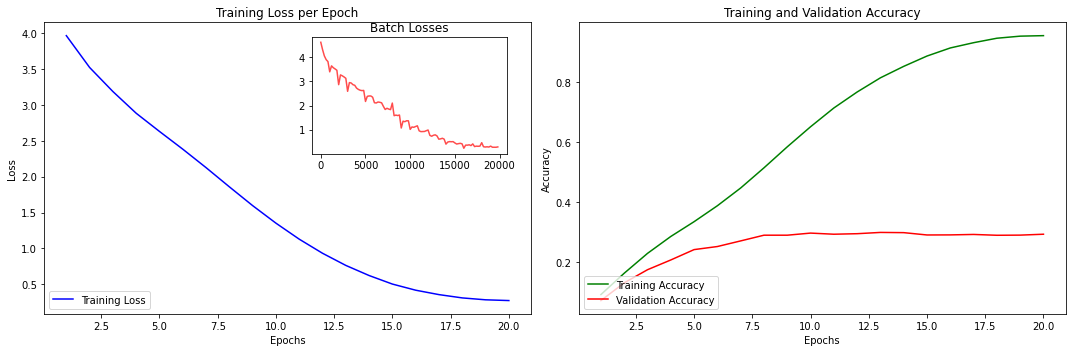

In [43]:
# Model
backbone = DINOBackbone()
backbone.load_state_dict(torch.load("dinoBackbone.pth"))
modelDino = DinoClassifier(backbone)

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(augmentedLT), torch.Tensor(augmentedLabelsLT).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(modelDino.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
modelDino.to(device)
lossesDINOAugLT, trainAccDINOAugLT, valAccDINOAugLT = train_model(trainLoader, valLoader, 20, modelDino, optimizer, scheduler, loss)

/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
1563it [00:17, 91.19it/s]


Test Accuracy - Overall: 16.28% | Head: 30.04% | Mid: 12.30% | Tail: 7.93%
Epoch 1/20 completed: val acc=0.163, train acc=0.201, epoch loss=3.380


1563it [00:15, 102.41it/s]


Test Accuracy - Overall: 22.85% | Head: 40.59% | Mid: 18.70% | Tail: 10.82%
Epoch 2/20 completed: val acc=0.229, train acc=0.488, epoch loss=2.007


1563it [00:16, 96.26it/s]


Test Accuracy - Overall: 26.35% | Head: 45.10% | Mid: 22.71% | Tail: 12.63%
Epoch 3/20 completed: val acc=0.264, train acc=0.649, epoch loss=1.331


1563it [00:18, 85.22it/s]


Test Accuracy - Overall: 27.88% | Head: 50.46% | Mid: 22.65% | Tail: 12.47%
Epoch 4/20 completed: val acc=0.279, train acc=0.763, epoch loss=0.889


1563it [00:17, 86.97it/s]


Test Accuracy - Overall: 28.07% | Head: 45.86% | Mid: 25.91% | Tail: 13.38%
Epoch 5/20 completed: val acc=0.281, train acc=0.856, epoch loss=0.549


1563it [00:17, 91.00it/s] 


Test Accuracy - Overall: 29.07% | Head: 49.71% | Mid: 26.04% | Tail: 12.72%
Epoch 6/20 completed: val acc=0.291, train acc=0.928, epoch loss=0.295


1563it [00:17, 91.39it/s] 


Test Accuracy - Overall: 28.27% | Head: 48.95% | Mid: 25.41% | Tail: 11.64%
Epoch 7/20 completed: val acc=0.283, train acc=0.969, epoch loss=0.146


1563it [00:16, 92.53it/s] 


Test Accuracy - Overall: 28.40% | Head: 47.62% | Mid: 26.47% | Tail: 11.97%
Epoch 8/20 completed: val acc=0.284, train acc=0.983, epoch loss=0.090


1563it [00:16, 95.06it/s] 


Test Accuracy - Overall: 28.70% | Head: 46.44% | Mid: 26.47% | Tail: 14.12%
Epoch 9/20 completed: val acc=0.287, train acc=0.987, epoch loss=0.062


1563it [00:18, 84.37it/s]


Test Accuracy - Overall: 27.38% | Head: 47.78% | Mid: 23.71% | Tail: 12.06%
Epoch 10/20 completed: val acc=0.274, train acc=0.992, epoch loss=0.042


1563it [00:17, 90.00it/s] 


Test Accuracy - Overall: 28.35% | Head: 47.78% | Mid: 25.78% | Tail: 12.55%
Epoch 11/20 completed: val acc=0.283, train acc=0.995, epoch loss=0.028


1563it [00:17, 91.10it/s] 


Test Accuracy - Overall: 29.75% | Head: 50.71% | Mid: 26.35% | Tail: 13.54%
Epoch 12/20 completed: val acc=0.297, train acc=0.997, epoch loss=0.018


1563it [00:17, 87.70it/s] 


Test Accuracy - Overall: 29.45% | Head: 50.29% | Mid: 26.54% | Tail: 12.72%
Epoch 13/20 completed: val acc=0.294, train acc=0.998, epoch loss=0.013


1563it [00:19, 81.49it/s]


Test Accuracy - Overall: 29.90% | Head: 50.54% | Mid: 26.47% | Tail: 14.04%
Epoch 14/20 completed: val acc=0.299, train acc=0.999, epoch loss=0.009


1563it [00:17, 88.38it/s] 


Test Accuracy - Overall: 29.70% | Head: 50.21% | Mid: 27.23% | Tail: 12.72%
Epoch 15/20 completed: val acc=0.297, train acc=0.999, epoch loss=0.006


1563it [00:19, 80.00it/s]


Test Accuracy - Overall: 30.50% | Head: 52.22% | Mid: 26.91% | Tail: 13.79%
Epoch 16/20 completed: val acc=0.305, train acc=1.000, epoch loss=0.003


1563it [00:17, 90.16it/s]


Test Accuracy - Overall: 30.28% | Head: 50.71% | Mid: 27.16% | Tail: 14.20%
Epoch 17/20 completed: val acc=0.303, train acc=1.000, epoch loss=0.003


1563it [00:16, 92.94it/s]


Test Accuracy - Overall: 30.65% | Head: 51.80% | Mid: 26.91% | Tail: 14.70%
Epoch 18/20 completed: val acc=0.306, train acc=1.000, epoch loss=0.002


1563it [00:17, 89.59it/s]


Test Accuracy - Overall: 30.08% | Head: 50.13% | Mid: 27.60% | Tail: 13.54%
Epoch 19/20 completed: val acc=0.301, train acc=1.000, epoch loss=0.002


1563it [00:17, 87.81it/s]


Test Accuracy - Overall: 30.25% | Head: 50.96% | Mid: 27.16% | Tail: 13.87%
Epoch 20/20 completed: val acc=0.302, train acc=1.000, epoch loss=0.001


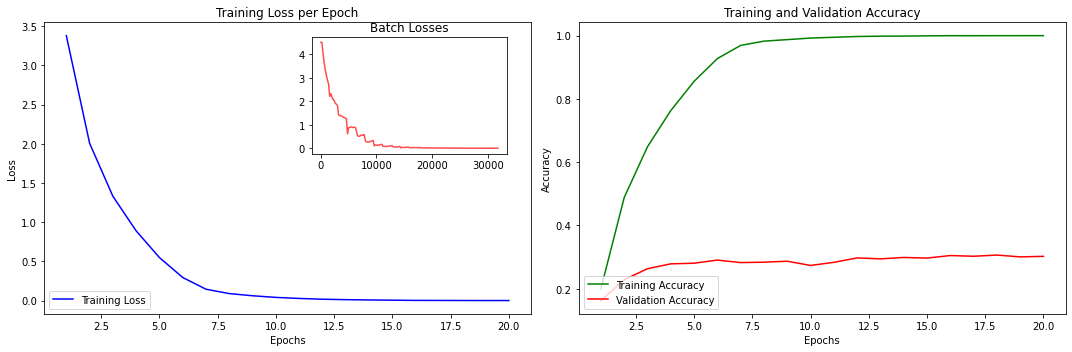

In [44]:
# Model
backbone = DINOBackbone()
backbone.load_state_dict(torch.load("dinoBackbone.pth"))
modelDino = DinoClassifier(backbone)

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(generatedLT), torch.Tensor(generatedLabelLT).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(modelDino.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
modelDino.to(device)
lossesDINOGenLT, trainAccDINOGenLT, valAccDINOGenLT = train_model(trainLoader, valLoader, 20, modelDino, optimizer, scheduler, loss)

## Dino Resnet50

In [45]:
class DINOBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = resnet50(pretrained=False)
        self.encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.encoder.fc = nn.Identity()

    def forward(self, x):
        return self.encoder(x)

In [46]:
studentBackbone = DINOBackbone()
teacherBackbone = DINOBackbone()

studentHead = DINOHead(in_dim=2048)
teacherHead = DINOHead(in_dim=2048)

student = nn.Sequential(studentBackbone, studentHead)
teacher = nn.Sequential(teacherBackbone, teacherHead)

for p in teacher.parameters():
    p.requires_grad = False

/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/javvaji.m/.local/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [47]:
student = student.to(device)
teacher = teacher.to(device)

optimizer = torch.optim.Adam(student.parameters(), lr=1e-3)

for epoch in range(20):
    for view1, view2 in dinoLoader:
        view1, view2 = view1.to(device), view2.to(device)

        student_out = student(view1)
        with torch.no_grad():
            teacher_out = teacher(view2)

        loss = dino_loss(student_out, teacher_out)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # EMA update of teacher
        with torch.no_grad():
            m = 0.996  # Momentum
            for param_q, param_k in zip(student.parameters(), teacher.parameters()):
                param_k.data = param_k.data * m + param_q.data * (1. - m)

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

torch.save(studentBackbone.state_dict(), "dinoBackbone1.pth")

Epoch 1, Loss: 10.3233
Epoch 2, Loss: 9.8624
Epoch 3, Loss: 9.0592
Epoch 4, Loss: 8.1430
Epoch 5, Loss: 7.0509
Epoch 6, Loss: 5.3168
Epoch 7, Loss: 3.5127
Epoch 8, Loss: 1.9309
Epoch 9, Loss: 0.9505
Epoch 10, Loss: 0.3937
Epoch 11, Loss: 0.1580
Epoch 12, Loss: 0.0578
Epoch 13, Loss: 0.0186
Epoch 14, Loss: 0.0050
Epoch 15, Loss: 0.0011
Epoch 16, Loss: 0.0002
Epoch 17, Loss: 0.0000
Epoch 18, Loss: 0.0000
Epoch 19, Loss: 0.0000
Epoch 20, Loss: 0.0000


In [48]:
class DinoClassifier(nn.Module):
    def __init__(self, backbone, num_classes=100):
        super().__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

498it [00:10, 46.35it/s]


Test Accuracy - Overall: 4.10% | Head: 13.47% | Mid: 0.19% | Tail: 0.00%
Epoch 1/20 completed: val acc=0.041, train acc=0.078, epoch loss=4.131


498it [00:10, 47.15it/s]


Test Accuracy - Overall: 7.42% | Head: 22.09% | Mid: 2.07% | Tail: 0.00%
Epoch 2/20 completed: val acc=0.074, train acc=0.136, epoch loss=3.728


498it [00:12, 40.62it/s]


Test Accuracy - Overall: 8.85% | Head: 25.61% | Mid: 2.82% | Tail: 0.25%
Epoch 3/20 completed: val acc=0.088, train acc=0.178, epoch loss=3.447


498it [00:11, 45.16it/s]


Test Accuracy - Overall: 11.70% | Head: 29.87% | Mid: 6.52% | Tail: 0.58%
Epoch 4/20 completed: val acc=0.117, train acc=0.214, epoch loss=3.237


498it [00:10, 48.77it/s]


Test Accuracy - Overall: 14.45% | Head: 36.40% | Mid: 7.65% | Tail: 1.73%
Epoch 5/20 completed: val acc=0.144, train acc=0.236, epoch loss=3.096


498it [00:12, 40.27it/s]


Test Accuracy - Overall: 11.18% | Head: 27.87% | Mid: 6.27% | Tail: 1.16%
Epoch 6/20 completed: val acc=0.112, train acc=0.282, epoch loss=2.877


498it [00:11, 42.46it/s]


Test Accuracy - Overall: 16.18% | Head: 38.08% | Mid: 9.03% | Tail: 3.96%
Epoch 7/20 completed: val acc=0.162, train acc=0.274, epoch loss=2.912


498it [00:11, 42.13it/s]


Test Accuracy - Overall: 19.80% | Head: 42.34% | Mid: 15.24% | Tail: 3.55%
Epoch 8/20 completed: val acc=0.198, train acc=0.340, epoch loss=2.582


498it [00:12, 40.46it/s]


Test Accuracy - Overall: 22.80% | Head: 46.44% | Mid: 17.38% | Tail: 6.61%
Epoch 9/20 completed: val acc=0.228, train acc=0.386, epoch loss=2.345


498it [00:11, 41.56it/s]


Test Accuracy - Overall: 23.97% | Head: 47.03% | Mid: 17.88% | Tail: 9.25%
Epoch 10/20 completed: val acc=0.240, train acc=0.431, epoch loss=2.139


498it [00:11, 42.09it/s]


Test Accuracy - Overall: 24.55% | Head: 46.28% | Mid: 21.46% | Tail: 7.18%
Epoch 11/20 completed: val acc=0.245, train acc=0.479, epoch loss=1.915


498it [00:11, 42.76it/s]


Test Accuracy - Overall: 25.62% | Head: 47.70% | Mid: 20.20% | Tail: 10.98%
Epoch 12/20 completed: val acc=0.256, train acc=0.531, epoch loss=1.670


498it [00:12, 40.66it/s]


Test Accuracy - Overall: 25.72% | Head: 47.45% | Mid: 21.20% | Tail: 10.24%
Epoch 13/20 completed: val acc=0.257, train acc=0.597, epoch loss=1.418


498it [00:11, 42.24it/s]


Test Accuracy - Overall: 26.75% | Head: 45.27% | Mid: 23.34% | Tail: 12.96%
Epoch 14/20 completed: val acc=0.268, train acc=0.663, epoch loss=1.164


498it [00:12, 40.62it/s]


Test Accuracy - Overall: 26.88% | Head: 46.53% | Mid: 23.40% | Tail: 12.06%
Epoch 15/20 completed: val acc=0.269, train acc=0.741, epoch loss=0.884


498it [00:12, 40.58it/s]


Test Accuracy - Overall: 27.73% | Head: 47.78% | Mid: 23.71% | Tail: 13.21%
Epoch 16/20 completed: val acc=0.277, train acc=0.804, epoch loss=0.685


498it [00:12, 40.07it/s]


Test Accuracy - Overall: 28.40% | Head: 47.78% | Mid: 25.66% | Tail: 12.88%
Epoch 17/20 completed: val acc=0.284, train acc=0.854, epoch loss=0.529


498it [00:11, 43.58it/s]


Test Accuracy - Overall: 27.40% | Head: 46.69% | Mid: 23.78% | Tail: 13.13%
Epoch 18/20 completed: val acc=0.274, train acc=0.893, epoch loss=0.422


498it [00:12, 40.38it/s]


Test Accuracy - Overall: 28.38% | Head: 47.45% | Mid: 25.78% | Tail: 12.96%
Epoch 19/20 completed: val acc=0.284, train acc=0.913, epoch loss=0.353


498it [00:11, 42.65it/s]


Test Accuracy - Overall: 27.82% | Head: 47.11% | Mid: 24.40% | Tail: 13.29%
Epoch 20/20 completed: val acc=0.278, train acc=0.921, epoch loss=0.326


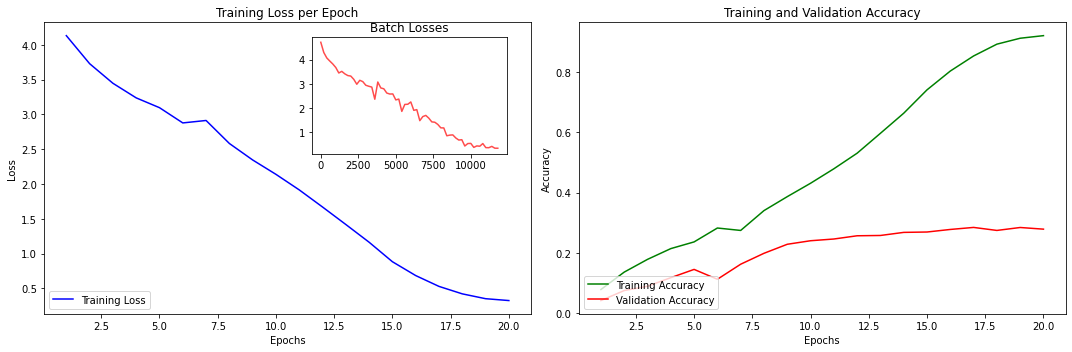

In [49]:
# Model
backbone = DINOBackbone()
backbone.load_state_dict(torch.load("dinoBackbone1.pth"))
modelDino = DinoClassifier(backbone)

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(trainDataLT), torch.Tensor(trainLabelLT).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(modelDino.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
modelDino.to(device)
losses50DINOLT, train50AccDINOLT, val50AccDINOLT = train_model(trainLoader, valLoader, 20, modelDino, optimizer, scheduler, loss)

/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
995it [00:23, 43.25it/s]


Test Accuracy - Overall: 4.58% | Head: 13.22% | Mid: 1.57% | Tail: 0.00%
Epoch 1/20 completed: val acc=0.046, train acc=0.064, epoch loss=4.157


995it [00:23, 43.11it/s]


Test Accuracy - Overall: 7.47% | Head: 21.59% | Mid: 2.57% | Tail: 0.00%
Epoch 2/20 completed: val acc=0.075, train acc=0.109, epoch loss=3.861


995it [00:21, 46.88it/s]


Test Accuracy - Overall: 8.43% | Head: 22.68% | Mid: 3.14% | Tail: 1.32%
Epoch 3/20 completed: val acc=0.084, train acc=0.141, epoch loss=3.637


995it [00:21, 47.29it/s]


Test Accuracy - Overall: 9.72% | Head: 27.95% | Mid: 3.01% | Tail: 0.58%
Epoch 4/20 completed: val acc=0.097, train acc=0.149, epoch loss=3.617


995it [00:21, 45.61it/s]


Test Accuracy - Overall: 10.57% | Head: 30.04% | Mid: 3.51% | Tail: 0.66%
Epoch 5/20 completed: val acc=0.106, train acc=0.156, epoch loss=3.559


995it [00:24, 40.87it/s]


Test Accuracy - Overall: 13.05% | Head: 32.38% | Mid: 6.52% | Tail: 2.56%
Epoch 6/20 completed: val acc=0.131, train acc=0.184, epoch loss=3.409


995it [00:23, 41.94it/s]


Test Accuracy - Overall: 14.82% | Head: 34.14% | Mid: 9.35% | Tail: 2.97%
Epoch 7/20 completed: val acc=0.148, train acc=0.199, epoch loss=3.315


995it [00:21, 45.26it/s]


Test Accuracy - Overall: 15.43% | Head: 37.32% | Mid: 8.16% | Tail: 3.39%
Epoch 8/20 completed: val acc=0.154, train acc=0.211, epoch loss=3.249


995it [00:20, 48.11it/s]


Test Accuracy - Overall: 17.32% | Head: 37.41% | Mid: 12.99% | Tail: 3.22%
Epoch 9/20 completed: val acc=0.173, train acc=0.239, epoch loss=3.083


995it [00:24, 41.37it/s]


Test Accuracy - Overall: 18.95% | Head: 36.57% | Mid: 14.87% | Tail: 6.94%
Epoch 10/20 completed: val acc=0.190, train acc=0.262, epoch loss=2.964


995it [00:22, 43.63it/s]


Test Accuracy - Overall: 19.55% | Head: 39.67% | Mid: 14.93% | Tail: 5.78%
Epoch 11/20 completed: val acc=0.196, train acc=0.290, epoch loss=2.827


995it [00:24, 40.95it/s]


Test Accuracy - Overall: 21.05% | Head: 38.91% | Mid: 18.63% | Tail: 6.61%
Epoch 12/20 completed: val acc=0.210, train acc=0.321, epoch loss=2.664


995it [00:21, 47.34it/s]


Test Accuracy - Overall: 21.82% | Head: 40.00% | Mid: 19.70% | Tail: 6.69%
Epoch 13/20 completed: val acc=0.218, train acc=0.359, epoch loss=2.494


995it [00:22, 44.50it/s]


Test Accuracy - Overall: 23.08% | Head: 41.26% | Mid: 20.51% | Tail: 8.51%
Epoch 14/20 completed: val acc=0.231, train acc=0.397, epoch loss=2.329


995it [00:23, 41.49it/s]


Test Accuracy - Overall: 22.48% | Head: 41.26% | Mid: 19.20% | Tail: 8.26%
Epoch 15/20 completed: val acc=0.225, train acc=0.432, epoch loss=2.168


995it [00:22, 43.85it/s]


Test Accuracy - Overall: 23.80% | Head: 42.18% | Mid: 20.33% | Tail: 10.24%
Epoch 16/20 completed: val acc=0.238, train acc=0.468, epoch loss=2.029


995it [00:20, 48.42it/s]


Test Accuracy - Overall: 23.28% | Head: 40.67% | Mid: 21.02% | Tail: 9.08%
Epoch 17/20 completed: val acc=0.233, train acc=0.496, epoch loss=1.898


995it [00:21, 46.42it/s]


Test Accuracy - Overall: 24.02% | Head: 41.84% | Mid: 21.83% | Tail: 9.33%
Epoch 18/20 completed: val acc=0.240, train acc=0.523, epoch loss=1.812


995it [00:23, 43.15it/s]


Test Accuracy - Overall: 23.67% | Head: 40.84% | Mid: 21.58% | Tail: 9.50%
Epoch 19/20 completed: val acc=0.237, train acc=0.543, epoch loss=1.740


995it [00:20, 48.44it/s]


Test Accuracy - Overall: 23.95% | Head: 41.51% | Mid: 21.77% | Tail: 9.50%
Epoch 20/20 completed: val acc=0.239, train acc=0.552, epoch loss=1.705


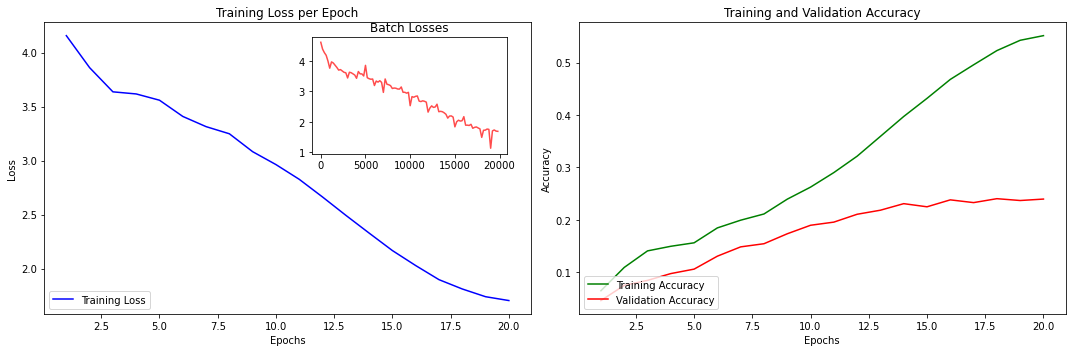

In [50]:
# Model
backbone = DINOBackbone()
backbone.load_state_dict(torch.load("dinoBackbone1.pth"))
modelDino = DinoClassifier(backbone)

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(augmentedLT), torch.Tensor(augmentedLabelsLT).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(modelDino.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
modelDino.to(device)
losses50DINOAugLT, train50AccDINOAugLT, val50AccDINOAugLT = train_model(trainLoader, valLoader, 20, modelDino, optimizer, scheduler, loss)

/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
1563it [00:32, 48.09it/s]


Test Accuracy - Overall: 8.33% | Head: 18.58% | Mid: 5.02% | Tail: 2.56%
Epoch 1/20 completed: val acc=0.083, train acc=0.068, epoch loss=4.142


1563it [00:32, 48.05it/s]


Test Accuracy - Overall: 15.55% | Head: 28.12% | Mid: 11.29% | Tail: 8.75%
Epoch 2/20 completed: val acc=0.155, train acc=0.226, epoch loss=3.168


1563it [00:32, 47.59it/s]


Test Accuracy - Overall: 18.88% | Head: 35.82% | Mid: 13.55% | Tail: 9.17%
Epoch 3/20 completed: val acc=0.189, train acc=0.367, epoch loss=2.497


1563it [00:31, 49.69it/s]


Test Accuracy - Overall: 22.78% | Head: 41.09% | Mid: 18.32% | Tail: 10.57%
Epoch 4/20 completed: val acc=0.228, train acc=0.489, epoch loss=1.961


1563it [00:35, 44.57it/s]


Test Accuracy - Overall: 19.53% | Head: 33.22% | Mid: 17.69% | Tail: 8.42%
Epoch 5/20 completed: val acc=0.195, train acc=0.571, epoch loss=1.589


1563it [00:32, 47.42it/s]


Test Accuracy - Overall: 26.62% | Head: 45.52% | Mid: 22.27% | Tail: 13.71%
Epoch 6/20 completed: val acc=0.266, train acc=0.658, epoch loss=1.239


1563it [00:31, 49.30it/s]


Test Accuracy - Overall: 26.92% | Head: 45.86% | Mid: 23.15% | Tail: 13.21%
Epoch 7/20 completed: val acc=0.269, train acc=0.736, epoch loss=0.926


1563it [00:32, 47.81it/s]


Test Accuracy - Overall: 26.45% | Head: 47.28% | Mid: 21.71% | Tail: 12.14%
Epoch 8/20 completed: val acc=0.265, train acc=0.789, epoch loss=0.722


1563it [00:34, 44.97it/s]


Test Accuracy - Overall: 27.20% | Head: 47.36% | Mid: 23.46% | Tail: 12.22%
Epoch 9/20 completed: val acc=0.272, train acc=0.858, epoch loss=0.480


1563it [00:34, 45.71it/s]


Test Accuracy - Overall: 27.05% | Head: 44.85% | Mid: 25.60% | Tail: 11.40%
Epoch 10/20 completed: val acc=0.271, train acc=0.902, epoch loss=0.335


1563it [00:33, 46.97it/s]


Test Accuracy - Overall: 27.70% | Head: 47.45% | Mid: 24.47% | Tail: 12.47%
Epoch 11/20 completed: val acc=0.277, train acc=0.939, epoch loss=0.210


1563it [00:33, 47.33it/s]


Test Accuracy - Overall: 29.07% | Head: 47.87% | Mid: 26.66% | Tail: 13.71%
Epoch 12/20 completed: val acc=0.291, train acc=0.968, epoch loss=0.120


1563it [00:34, 44.66it/s]


Test Accuracy - Overall: 27.45% | Head: 44.60% | Mid: 25.47% | Tail: 13.13%
Epoch 13/20 completed: val acc=0.275, train acc=0.979, epoch loss=0.078


1563it [00:32, 48.10it/s]


Test Accuracy - Overall: 28.10% | Head: 49.04% | Mid: 24.28% | Tail: 12.47%
Epoch 14/20 completed: val acc=0.281, train acc=0.987, epoch loss=0.056


1563it [00:33, 46.52it/s]


Test Accuracy - Overall: 24.90% | Head: 42.51% | Mid: 22.58% | Tail: 10.57%
Epoch 15/20 completed: val acc=0.249, train acc=0.993, epoch loss=0.035


1563it [00:33, 46.90it/s]


Test Accuracy - Overall: 28.85% | Head: 50.96% | Mid: 24.97% | Tail: 12.14%
Epoch 16/20 completed: val acc=0.288, train acc=0.993, epoch loss=0.032


1563it [00:32, 47.60it/s]


Test Accuracy - Overall: 29.45% | Head: 49.87% | Mid: 26.54% | Tail: 13.13%
Epoch 17/20 completed: val acc=0.294, train acc=0.998, epoch loss=0.013


1563it [00:33, 47.30it/s]


Test Accuracy - Overall: 29.20% | Head: 50.21% | Mid: 25.60% | Tail: 13.21%
Epoch 18/20 completed: val acc=0.292, train acc=0.999, epoch loss=0.010


1563it [00:33, 46.92it/s]


Test Accuracy - Overall: 29.78% | Head: 50.54% | Mid: 26.29% | Tail: 13.87%
Epoch 19/20 completed: val acc=0.298, train acc=0.999, epoch loss=0.008


1563it [00:35, 44.04it/s]


Test Accuracy - Overall: 28.85% | Head: 49.62% | Mid: 25.22% | Tail: 13.13%
Epoch 20/20 completed: val acc=0.288, train acc=1.000, epoch loss=0.007


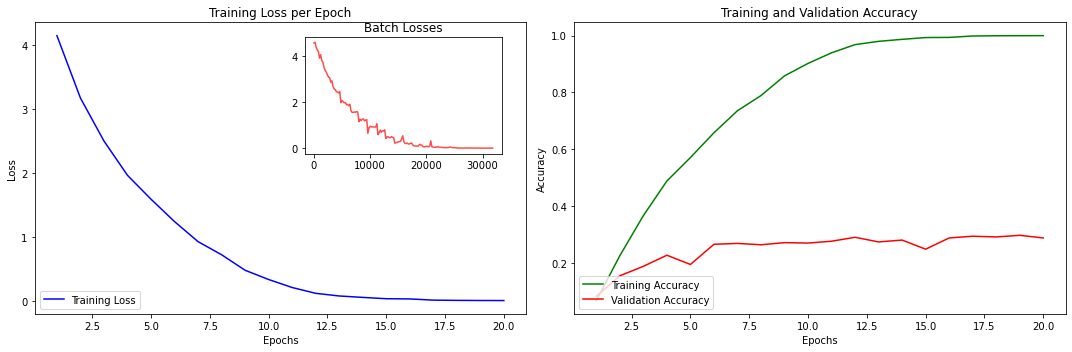

In [51]:
# Model
backbone = DINOBackbone()
backbone.load_state_dict(torch.load("dinoBackbone1.pth"))
modelDino = DinoClassifier(backbone)

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(generatedLT), torch.Tensor(generatedLabelLT).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(modelDino.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
modelDino.to(device)
losses50DINOGenLT, train50AccDINOGenLT, val50AccDINOGenLT = train_model(trainLoader, valLoader, 20, modelDino, optimizer, scheduler, loss)